# Data Processing

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully")

All libraries imported successfully


In [3]:
# Load data
file_path = "/home/aryan/Graph_ML/bis_dataset.csv"
df_raw = pd.read_csv(file_path)

print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nFirst few rows:")
df_raw.head()

Dataset shape: (226731, 164)

Columns: ['FREQ', 'Frequency', 'L_MEASURE', 'Measure', 'L_REP_CTY', 'Reporting country', 'CBS_BANK_TYPE', 'CBS bank type', 'CBS_BASIS', 'CBS reporting basis', 'L_POSITION', 'Balance sheet position', 'L_INSTR', 'Type of instruments', 'REM_MATURITY', 'Remaining maturity', 'CURR_TYPE_BOOK', 'Currency type of booking location', 'L_CP_SECTOR', 'Counterparty sector', 'L_CP_COUNTRY', 'Counterparty country', 'TIME_FORMAT', 'Time Format', 'COLLECTION', 'Collection Indicator', 'ORG_VISIBILITY', 'Organisation visibility', 'Series', '1983-Q4', '1984-Q2', '1984-Q4', '1985-Q2', '1985-Q4', '1986-Q2', '1986-Q4', '1987-Q2', '1987-Q4', '1988-Q2', '1988-Q4', '1989-Q2', '1989-Q4', '1990-Q2', '1990-Q4', '1991-Q2', '1991-Q4', '1992-Q2', '1992-Q4', '1993-Q2', '1993-Q4', '1994-Q2', '1994-Q4', '1995-Q2', '1995-Q4', '1996-Q2', '1996-Q4', '1997-Q2', '1997-Q4', '1998-Q2', '1998-Q4', '1999-Q2', '1999-Q4', '2000-Q1', '2000-Q2', '2000-Q3', '2000-Q4', '2001-Q1', '2001-Q2', '2001-Q3', '20

FREQ  Frequency L_MEASURE          Measure L_REP_CTY Reporting country  \
0    Q  Quarterly         B  Break in stocks        CA            Canada   
1    Q  Quarterly         B  Break in stocks        CA            Canada   
2    Q  Quarterly         B  Break in stocks        CA            Canada   
3    Q  Quarterly         B  Break in stocks        CA            Canada   
4    Q  Quarterly         B  Break in stocks        CA            Canada   

  CBS_BANK_TYPE                                      CBS bank type CBS_BASIS  \
0            4O  All excluding 4C banks, excl. domestic positio...         F   
1            4O  All excluding 4C banks, excl. domestic positio...         F   
2            4O  All excluding 4C banks, excl. domestic positio...         F   
3            4O  All excluding 4C banks, excl. domestic positio...         F   
4            4O  All excluding 4C banks, excl. domestic positio...         F   

            CBS reporting basis  ... 2023-Q1 2023-Q2 2023-Q3 2023-Q4 2024-Q1  \
0  Immediate counterparty basis  ...     NaN     NaN     NaN  645.96     NaN   
1  Immediate counterparty basis  ...     NaN     NaN     NaN     NaN     NaN   
2  Immediate counterparty basis  ...     NaN     NaN     NaN     NaN     NaN   
3  Immediate counterparty basis  ...     NaN     NaN     NaN     NaN     NaN   
4  Immediate counterparty basis  ...     NaN     NaN     NaN     NaN     NaN   

  2024-Q2 2024-Q3 2024-Q4 2025-Q1 2025-Q2  
0  305.97     NaN     NaN     NaN     NaN  
1    1.20     NaN     NaN     NaN     NaN  
2    0.25     NaN     NaN     NaN     NaN  
3    1.52     NaN     NaN     NaN     NaN  
4    0.42     NaN     NaN     NaN     NaN  

[5 rows x 164 columns]

In [4]:
# Check data types and missing values
print("Data Info:")
print("="*60)
df_raw.info()

print("\n\nMissing Values:")
print("="*60)
print(df_raw.isnull().sum())

print("\n\nSample Values:")
print("="*60)
for col in df_raw.columns[:5]:  # First 5 columns
    print(f"\n{col}:")
    print(df_raw[col].value_counts().head(3))

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226731 entries, 0 to 226730
Columns: 164 entries, FREQ to 2025-Q2
dtypes: float64(137), object(27)
memory usage: 283.7+ MB


Missing Values:
FREQ              0
Frequency         0
L_MEASURE         0
Measure           0
L_REP_CTY         0
              ...  
2024-Q2      149162
2024-Q3      149416
2024-Q4      152705
2025-Q1      149079
2025-Q2      154412
Length: 164, dtype: int64


Sample Values:

FREQ:
FREQ
Q    226731
Name: count, dtype: int64

Frequency:
Frequency
Quarterly    226731
Name: count, dtype: int64

L_MEASURE:
L_MEASURE
S    178310
B     48421
Name: count, dtype: int64

Measure:
Measure
Amounts outstanding / Stocks    178310
Break in stocks                  48421
Name: count, dtype: int64

L_REP_CTY:
L_REP_CTY
5A    43763
FR    11338
ES    11118
Name: count, dtype: int64


# Data Cleaning for forming the network

In [37]:
class BISDataCleaner:
    """Clean BIS data for network construction"""
    
    def __init__(self):
        # BIS codes to exclude (aggregates, unallocated, special codes)
        self.exclude_codes = {
            '5J', '5Z', '5A', '5M', '5Y', '5R', '5K', '5C', '4L', '4T',
            '3C', '4U', '4W', '4Y', '1N', '2N', '1W', '1Z', '2R', '2B', 
            '2H', '2O', '1C', '1G', '1E', '3P', '3X', '3Z', '3W', '3Y',
            '1B', '1M', '6I', '6J', '6O', '6P', 'C1', 'C2', '1Q', '5N'
        }
    
    def clean(self, df, reporter_col, counterparty_col, amount_col, time_col):
        """
        Clean BIS data according to network rules
        
        Parameters:
        - df: Raw dataframe
        - reporter_col: Name of reporter country column
        - counterparty_col: Name of counterparty country column
        - amount_col: Name of amount column
        - time_col: Name of time/quarter column
        """
        print("=" * 60)
        print("CLEANING BIS DATA")
        print("=" * 60)
        
        original_rows = len(df)
        df = df.copy()
        
        # Step 1: Remove missing values
        print(f"\nOriginal rows: {original_rows:,}")
        df = df.dropna(subset=[reporter_col, counterparty_col, amount_col])
        print(f"After removing NaN: {len(df):,} rows")
        
        # Step 2: Remove BIS aggregate codes
        before = len(df)
        df = df[~df[counterparty_col].isin(self.exclude_codes)]
        df = df[~df[reporter_col].isin(self.exclude_codes)]
        print(f"After removing aggregates: {len(df):,} rows (-{before - len(df):,})")
        
        # Step 3: Remove domestic positions
        before = len(df)
        df = df[df[reporter_col] != df[counterparty_col]]
        print(f"After removing domestic: {len(df):,} rows (-{before - len(df):,})")
        
        # Step 4: Keep only valid 2-letter ISO codes
        def is_valid_iso(code):
            if pd.isna(code):
                return False
            code = str(code).strip()
            return len(code) == 2 and code.isalpha() and code.isupper()
        
        before = len(df)
        df = df[df[reporter_col].apply(is_valid_iso) & 
                df[counterparty_col].apply(is_valid_iso)]
        print(f"After filtering ISO codes: {len(df):,} rows (-{before - len(df):,})")
        
        # Step 5: Remove zero/negative amounts
        before = len(df)
        df = df[df[amount_col] > 0]
        print(f"After removing ≤0 amounts: {len(df):,} rows (-{before - len(df):,})")
        
        # Step 6: Aggregate duplicates
        before = len(df)
        df = df.groupby([time_col, reporter_col, counterparty_col], 
                       as_index=False)[amount_col].sum()
        print(f"After aggregation: {len(df):,} unique pairs")
        
        # Summary
        print("\n" + "=" * 60)
        print("CLEANING SUMMARY")
        print("=" * 60)
        print(f"Reduction: {original_rows:,} → {len(df):,} ({(1-len(df)/original_rows)*100:.1f}% removed)")
        print(f"\nUnique reporters: {df[reporter_col].nunique()}")
        print(f"Unique counterparties: {df[counterparty_col].nunique()}")
        print(f"Unique time periods: {df[time_col].nunique()}")
        print(f"Total volume: ${df[amount_col].sum():,.0f}M")
        
        return df
    
    def show_top_countries(self, df, reporter_col, counterparty_col, amount_col, n=10):
        """Show top countries by lending/borrowing"""
        print("\n" + "=" * 60)
        print(f"TOP {n} COUNTRIES")
        print("=" * 60)
        
        # Top lenders
        top_lenders = df.groupby(reporter_col)[amount_col].sum().sort_values(ascending=False).head(n)
        print(f"\nTop {n} Lenders (by total claims):")
        for i, (country, amount) in enumerate(top_lenders.items(), 1):
            print(f"  {i:2d}. {country}: ${amount:>15,.0f}M")
        
        # Top borrowers
        top_borrowers = df.groupby(counterparty_col)[amount_col].sum().sort_values(ascending=False).head(n)
        print(f"\nTop {n} Borrowers (by total liabilities):")
        for i, (country, amount) in enumerate(top_borrowers.items(), 1):
            print(f"  {i:2d}. {country}: ${amount:>15,.0f}M")

# Initialize cleaner
cleaner = BISDataCleaner()
print(" Cleaner initialized")

 Cleaner initialized


In [40]:
print("=" * 60)
print("RESHAPING BIS DATA")
print("=" * 60)

# Step 1: Filter for stocks only (not breaks)
print("\nStep 1: Filtering for stocks (L_MEASURE = 'S')...")
df_stocks = df_raw[df_raw['L_MEASURE'] == 'S'].copy()
print(f"Rows after filtering: {len(df_stocks):,}")

# Step 2: Keep only relevant columns + quarter columns
metadata_cols = ['L_REP_CTY', 'L_CP_COUNTRY', 'L_POSITION', 'L_INSTR', 
                 'L_CP_SECTOR', 'CBS_BANK_TYPE', 'CBS_BASIS']

# Find quarter columns (start from 1983-Q4)
quarter_cols = [col for col in df_raw.columns if '-Q' in str(col)]
print(f"\nQuarter columns found: {len(quarter_cols)} (from {quarter_cols[0]} to {quarter_cols[-1]})")

# Keep only metadata + quarters
df_filtered = df_stocks[metadata_cols + quarter_cols].copy()

# Step 3: Reshape from wide to long


df_long = pd.melt(df_filtered, 
                  id_vars=metadata_cols,
                  value_vars=quarter_cols,
                  var_name='Quarter',
                  value_name='Amount')

print(f" Reshaped to {len(df_long):,} rows")

# Step 4: Remove missing values
print("\nStep 4: Removing missing values...")
df_long = df_long.dropna(subset=['Amount'])
print(f"After removing NaN: {len(df_long):,} rows")

# Step 5: Convert amount to numeric
df_long['Amount'] = pd.to_numeric(df_long['Amount'], errors='coerce')
df_long = df_long[df_long['Amount'] > 0]
print(f"After removing ≤0: {len(df_long):,} rows")

print("\n Data reshaped successfully!")
df_long.head()

RESHAPING BIS DATA

Step 1: Filtering for stocks (L_MEASURE = 'S')...
Rows after filtering: 178,310

Quarter columns found: 135 (from 1983-Q4 to 2025-Q2)
 Reshaped to 24,071,850 rows

Step 4: Removing missing values...
After removing NaN: 6,211,476 rows
After removing ≤0: 5,863,568 rows

 Data reshaped successfully!


L_REP_CTY L_CP_COUNTRY L_POSITION L_INSTR L_CP_SECTOR CBS_BANK_TYPE  \
797         CH           3P          C       A           A            4M   
2156        BE           5J          I       A           A            4R   
2697        CA           3P          M       A           A            4O   
2698        CA           5J          M       A           A            4O   
3181        JP           IR          I       A           A            4R   

     CBS_BASIS  Quarter   Amount  
797          F  1983-Q4  20145.0  
2156         F  1983-Q4    298.0  
2697         F  1983-Q4   3338.0  
2698         F  1983-Q4   3338.0  
3181         F  1983-Q4    732.0

In [7]:
class BISDataCleaner:
    def __init__(self):
        # BIS aggregate codes to exclude
        self.exclude_codes = {
            '5J', '5Z', '5A', '5M', '5Y', '5R', '5K', '5C', '4L', '4T',
            '3C', '4U', '4W', '4Y', '1N', '2N', '1W', '1Z', '2R', '2B', 
            '2H', '2O', '1C', '1G', '1E', '3P', '3X', '3Z', '3W', '3Y',
            '1B', '1M', '6I', '6J', '6O', '6P', 'C1', 'C2', '1Q', '5N'
        }
    
    def clean(self, df):
        print("=" * 60)
        print("CLEANING DATA")
        print("=" * 60)
        
        original = len(df)
        df = df.copy()
        
        # Step 1: Remove BIS aggregates
        print(f"\nOriginal rows: {original:,}")
        before = len(df)
        df = df[~df['L_CP_COUNTRY'].isin(self.exclude_codes)]
        df = df[~df['L_REP_CTY'].isin(self.exclude_codes)]
        print(f"After removing aggregates: {len(df):,} (-{before-len(df):,})")
        
        # Step 2: Remove domestic positions
        before = len(df)
        df = df[df['L_REP_CTY'] != df['L_CP_COUNTRY']]
        print(f"After removing domestic: {len(df):,} (-{before-len(df):,})")
        
        # Step 3: Keep only valid ISO codes
        def is_valid_iso(code):
            if pd.isna(code):
                return False
            code = str(code).strip()
            return len(code) == 2 and code.isalpha() and code.isupper()
        
        before = len(df)
        df = df[df['L_REP_CTY'].apply(is_valid_iso) & 
                df['L_CP_COUNTRY'].apply(is_valid_iso)]
        print(f"After ISO filtering: {len(df):,} (-{before-len(df):,})")
        
        # Step 4: Aggregate by reporter-counterparty-quarter
        print("\nAggregating by reporter-counterparty-quarter...")
        df = df.groupby(['Quarter', 'L_REP_CTY', 'L_CP_COUNTRY'], 
                       as_index=False)['Amount'].sum()
        
        print("\n" + "=" * 60)
        print("CLEANING SUMMARY")
        print("=" * 60)
        print(f"Final rows: {len(df):,}")
        print(f"Reduction: {(1-len(df)/original)*100:.1f}%")
        print(f"\nUnique reporters: {df['L_REP_CTY'].nunique()}")
        print(f"Unique counterparties: {df['L_CP_COUNTRY'].nunique()}")
        print(f"Unique quarters: {df['Quarter'].nunique()}")
        print(f"Date range: {df['Quarter'].min()} to {df['Quarter'].max()}")
        print(f"Total volume: ${df['Amount'].sum():,.0f}M")
        
        return df
    
    def show_top_countries(self, df, n=10):
        print("\n" + "=" * 60)
        print(f"TOP {n} COUNTRIES")
        print("=" * 60)
        
        # Top lenders
        top_lenders = df.groupby('L_REP_CTY')['Amount'].sum().sort_values(ascending=False).head(n)
        print(f"\nTop {n} Lenders:")
        for i, (country, amount) in enumerate(top_lenders.items(), 1):
            print(f"  {i:2d}. {country}: ${amount:>15,.0f}M")
        
        # Top borrowers
        top_borrowers = df.groupby('L_CP_COUNTRY')['Amount'].sum().sort_values(ascending=False).head(n)
        print(f"\nTop {n} Borrowers:")
        for i, (country, amount) in enumerate(top_borrowers.items(), 1):
            print(f"  {i:2d}. {country}: ${amount:>15,.0f}M")

# Clean the data
cleaner = BISDataCleaner()
df_clean = cleaner.clean(df_long)
cleaner.show_top_countries(df_clean, n=15)

CLEANING DATA

Original rows: 5,863,568
After removing aggregates: 3,762,165 (-2,101,403)
After removing domestic: 3,749,645 (-12,520)
After ISO filtering: 3,717,498 (-32,147)

Aggregating by reporter-counterparty-quarter...

CLEANING SUMMARY
Final rows: 289,605
Reduction: 95.1%

Unique reporters: 28
Unique counterparties: 223
Unique quarters: 135
Date range: 1983-Q4 to 2025-Q2
Total volume: $23,333,687,442M

TOP 15 COUNTRIES

Top 15 Lenders:
   1. GB: $  4,262,478,414M
   2. FR: $  3,079,026,165M
   3. US: $  2,978,067,420M
   4. JP: $  2,773,887,895M
   5. DE: $  2,054,999,101M
   6. ES: $  1,482,441,546M
   7. CH: $  1,452,063,734M
   8. CA: $  1,127,520,395M
   9. IT: $    782,646,468M
  10. AU: $    637,516,019M
  11. NL: $    583,933,070M
  12. SE: $    538,880,376M
  13. BE: $    391,762,548M
  14. AT: $    272,301,054M
  15. TW: $    239,928,995M

Top 15 Borrowers:
   1. US: $  5,610,514,973M
   2. GB: $  2,608,778,905M
   3. DE: $  1,383,302,543M
   4. FR: $  1,211,549,293M
  

In [10]:
# Save cleaned data
output_path = "/home/aryan/Graph_ML/bis_clean.csv"
df_clean.to_csv(output_path, index=False)
print(f" Saved cleaned data to: {output_path}")

print(f"\nCleaned data shape: {df_clean.shape}")
print(f"Columns: {list(df_clean.columns)}")
df_clean.head(10)

 Saved cleaned data to: /home/aryan/Graph_ML/bis_clean.csv

Cleaned data shape: (289605, 4)
Columns: ['Quarter', 'L_REP_CTY', 'L_CP_COUNTRY', 'Amount']


Quarter L_REP_CTY L_CP_COUNTRY  Amount
0  1983-Q4        AT           AE   364.0
1  1983-Q4        AT           AN    88.0
2  1983-Q4        AT           AO     4.0
3  1983-Q4        AT           AR   756.0
4  1983-Q4        AT           AU    60.0
5  1983-Q4        AT           BB   104.0
6  1983-Q4        AT           BD    20.0
7  1983-Q4        AT           BF    12.0
8  1983-Q4        AT           BG   968.0
9  1983-Q4        AT           BH  1052.0

SyntaxError: invalid syntax (3334071390.py, line 45)

# Network Building

In [ ]:
# Select latest quarter
available_quarters = sorted(df_clean['Quarter'].unique())
print(f"Available quarters: {len(available_quarters)}")
print(f"Range: {available_quarters[0]} to {available_quarters[-1]}")

# Pick latest
selected_quarter = available_quarters[-1]
print(f"\n Building network for: {selected_quarter}")

# Filter data
df_period = df_clean[df_clean['Quarter'] == selected_quarter].copy()
print(f"Bilateral relationships: {len(df_period):,}")

# Create directed network
G = nx.DiGraph()

for _, row in df_period.iterrows():
    source = row['L_REP_CTY']
    target = row['L_CP_COUNTRY']
    weight = row['Amount']
    G.add_edge(source, target, weight=weight)

# Summary
print("\n" + "=" * 60)
print(f"NETWORK: {selected_quarter}")
print("=" * 60)
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.4f}")
print(f"Avg degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

total_volume = sum(nx.get_edge_attributes(G, 'weight').values())
print(f"Total volume: ${total_volume:,.0f}M")

# Static Network Analysis

In [12]:
# Calculate stats
print("Calculating network statistics...")

stats = {}
stats['nodes'] = G.number_of_nodes()
stats['edges'] = G.number_of_edges()
stats['density'] = nx.density(G)
stats['avg_degree'] = sum(dict(G.degree()).values()) / G.number_of_nodes()

try:
    stats['avg_clustering'] = nx.average_clustering(G)
except:
    stats['avg_clustering'] = 0

stats['wcc_count'] = nx.number_weakly_connected_components(G)
stats['scc_count'] = nx.number_strongly_connected_components(G)

largest_wcc = max(nx.weakly_connected_components(G), key=len)
largest_scc = max(nx.strongly_connected_components(G), key=len)
stats['largest_wcc'] = len(largest_wcc)
stats['largest_scc'] = len(largest_scc)

print("\n" + "=" * 60)
print("NETWORK STATISTICS")
print("=" * 60)
for key, value in stats.items():
    if isinstance(value, float):
        print(f"{key:.<35} {value:.4f}")
    else:
        print(f"{key:.<35} {value}")

Calculating network statistics...

NETWORK STATISTICS
nodes.............................. 217
edges.............................. 2849
density............................ 0.0608
avg_degree......................... 26.2581
avg_clustering..................... 0.8659
wcc_count.......................... 1
scc_count.......................... 191
largest_wcc........................ 217
largest_scc........................ 27


In [15]:
print("Calculating centrality measures...")

# Degree
in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Strength (weighted degree)
in_str = dict(G.in_degree(weight='weight'))
out_str = dict(G.out_degree(weight='weight'))

# Betweenness
print("  - Betweenness centrality...")
betweenness = nx.betweenness_centrality(G, weight='weight')

# PageRank
print("  - PageRank...")
pagerank = nx.pagerank(G, weight='weight')

# Create dataframe
df_centrality = pd.DataFrame({
    'Country': list(G.nodes()),
    'In_Degree': [in_deg[n] for n in G.nodes()],
    'Out_Degree': [out_deg[n] for n in G.nodes()],
    'In_Strength_M': [in_str[n] for n in G.nodes()],
    'Out_Strength_M': [out_str[n] for n in G.nodes()],
    'Betweenness': [betweenness[n] for n in G.nodes()],
    'PageRank': [pagerank[n] for n in G.nodes()]
})

print(" Centrality calculations complete\n")
df_centrality.head(10)

Calculating centrality measures...
  - Betweenness centrality...
  - PageRank...
 Centrality calculations complete



Country  In_Degree  Out_Degree  In_Strength_M  Out_Strength_M  Betweenness  \
0      AT         24         172    2268405.959    5.210148e+06     0.003165   
1      AD         12           0       8627.189    0.000000e+00     0.000000   
2      AE         25           0    3003199.513    0.000000e+00     0.000000   
3      AF          8           0        193.521    0.000000e+00     0.000000   
4      AL         12           0      35316.805    0.000000e+00     0.000000   
5      AM         11           0       5795.709    0.000000e+00     0.000000   
6      AO         11           0      77362.052    0.000000e+00     0.000000   
7      AR         24           0     468157.003    0.000000e+00     0.000000   
8      AU         24         169    5514645.457    1.123766e+07     0.012898   
9      AW          6           0        743.038    0.000000e+00     0.000000   

   PageRank  
0  0.005223  
1  0.003610  
2  0.005657  
3  0.003607  
4  0.003655  
5  0.003609  
6  0.003693  
7  0.003860  
8  0.006374  
9  0.003607

CREATING INDIVIDUAL CENTRALITY PLOTS

1. Creating Out-Degree plot...


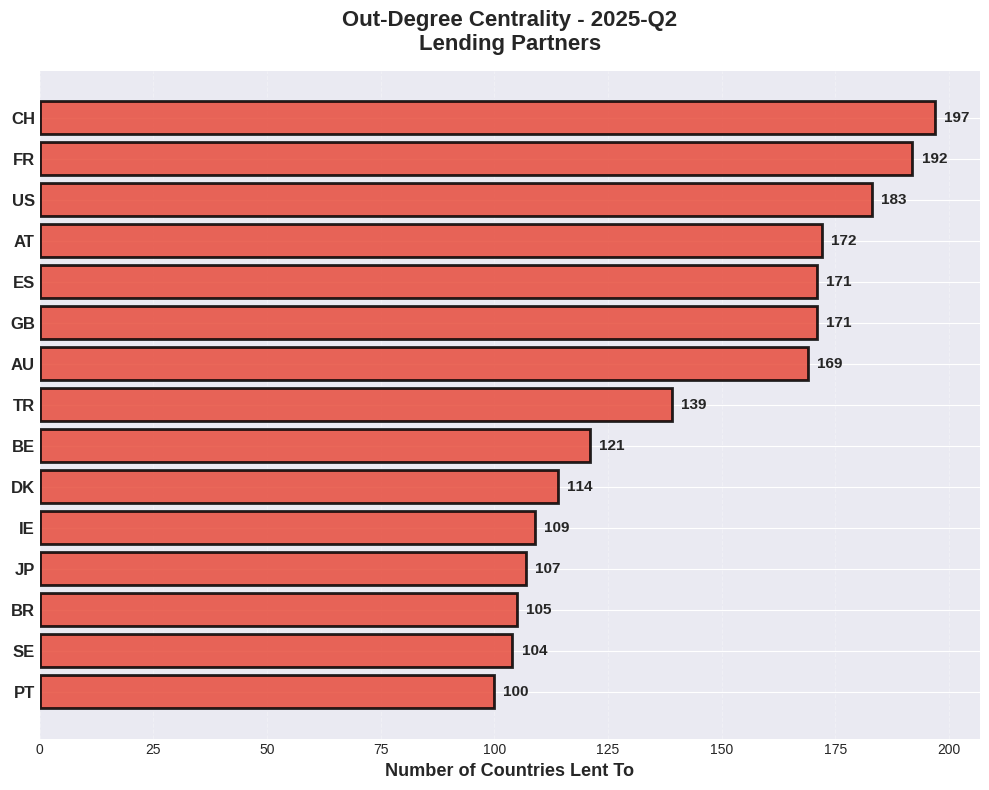

2. Creating In-Degree plot...


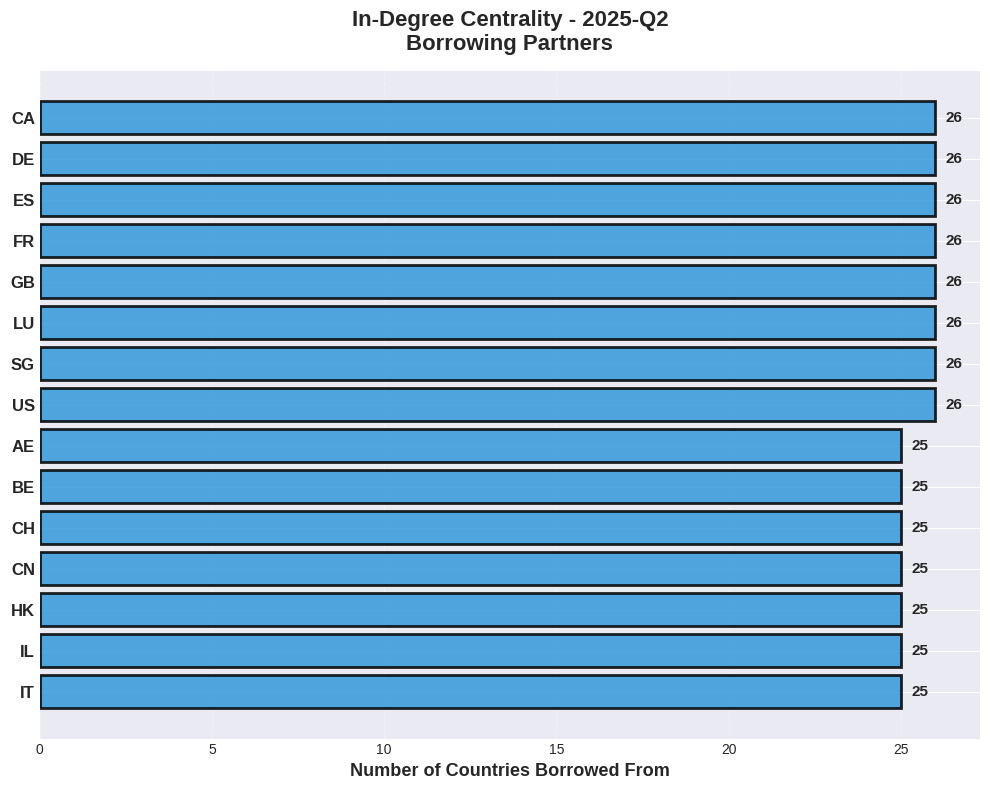

3. Creating Out-Strength plot...


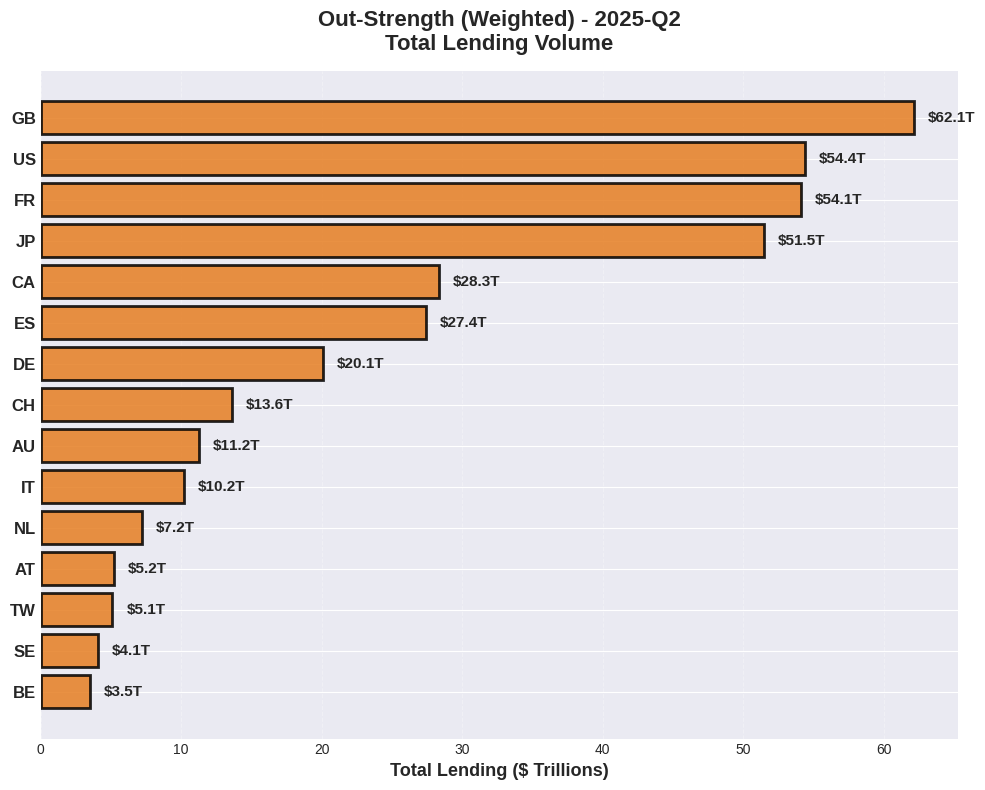

4. Creating In-Strength plot...


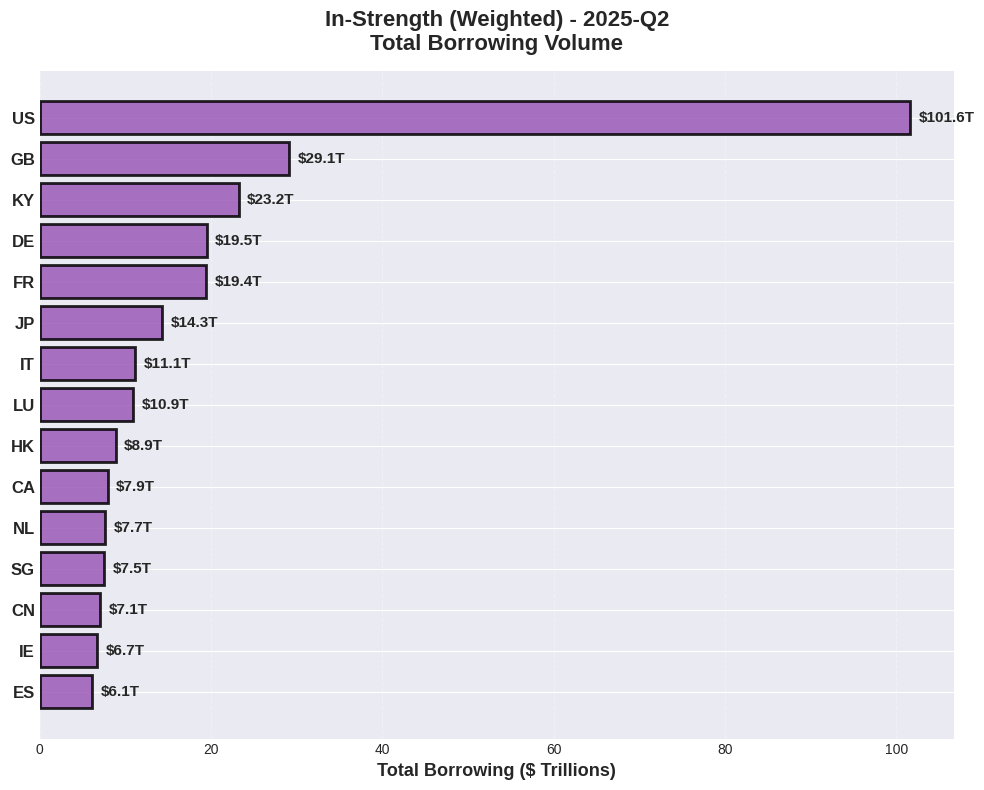

5. Creating Betweenness plot...


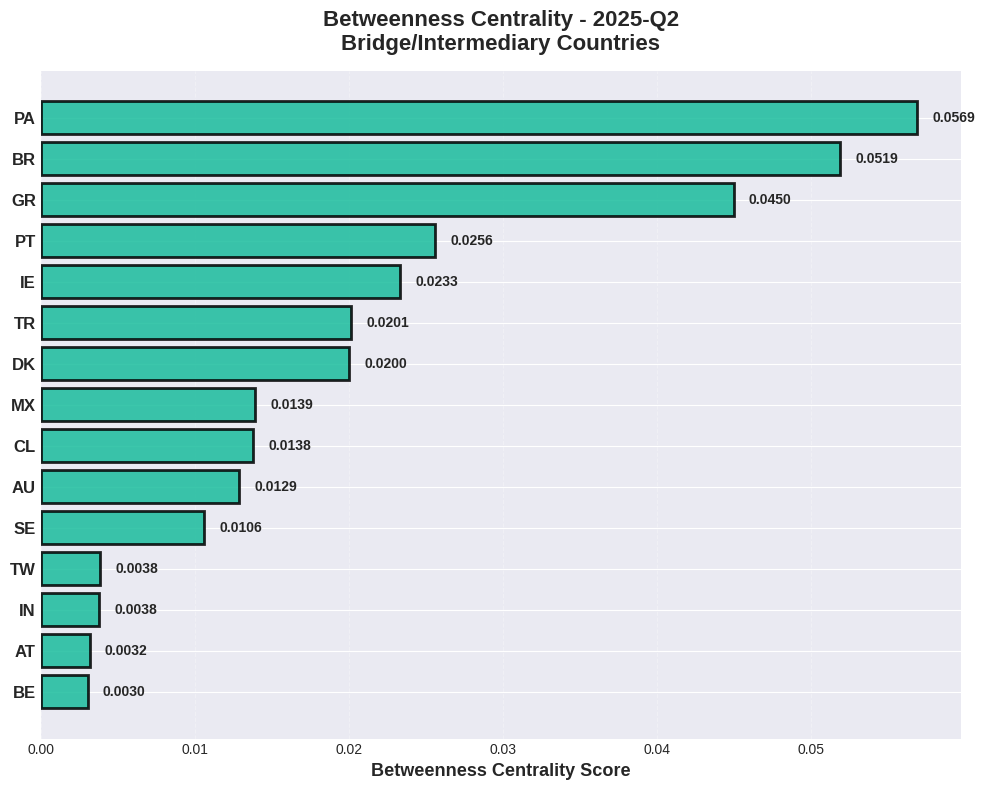

6. Creating PageRank plot...


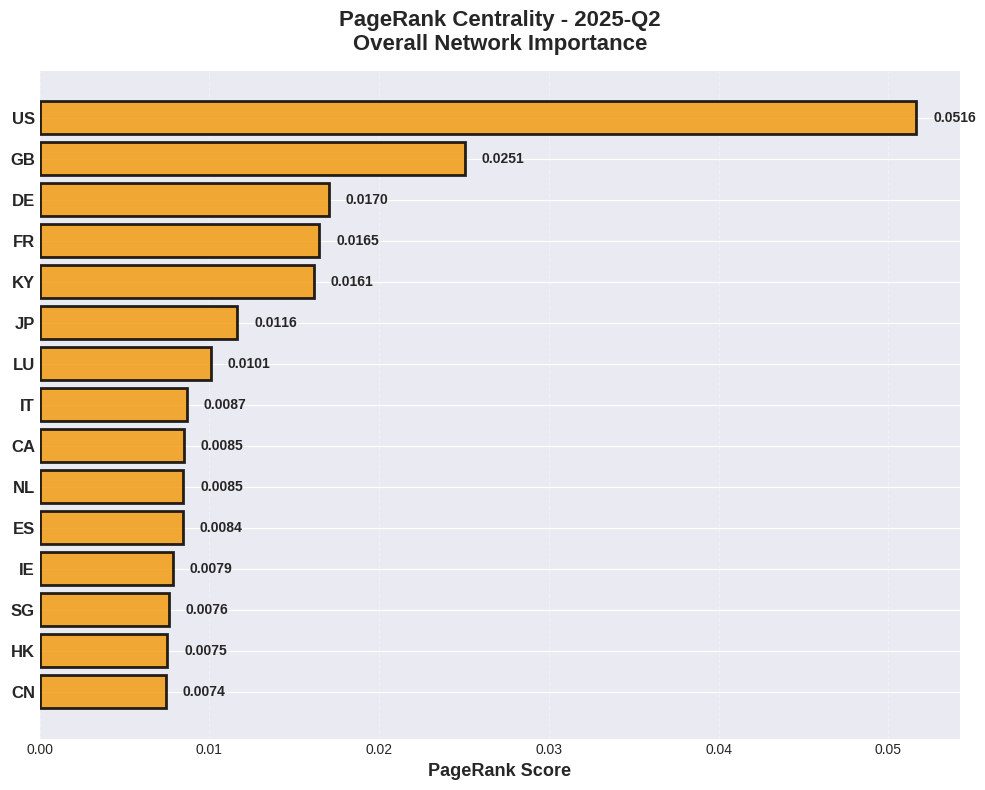

7. Creating Net Position plot...


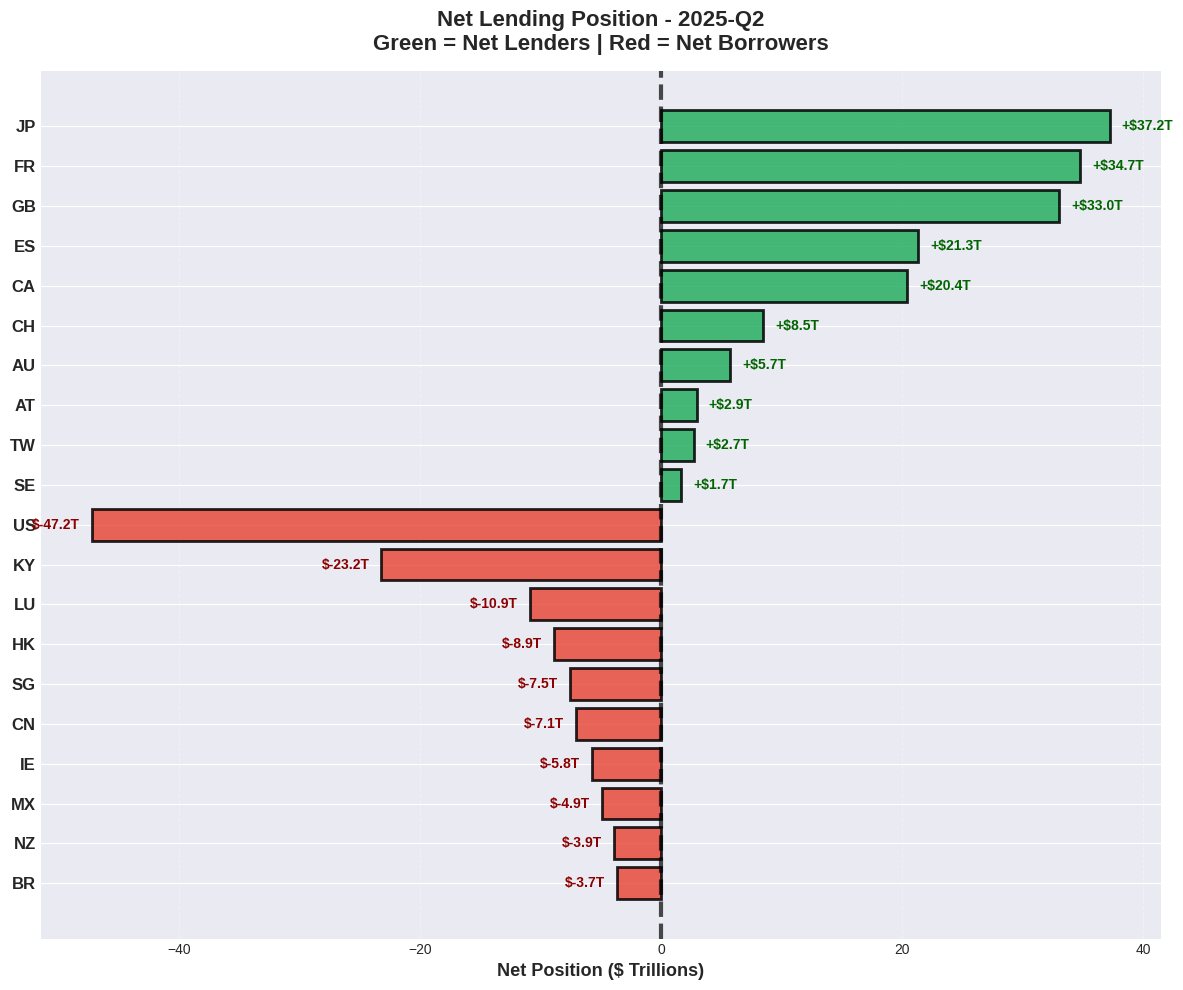


ALL INDIVIDUAL PLOTS SAVED!

Saved files:
  1. centrality_out_degree.png
  2. centrality_in_degree.png
  3. centrality_out_strength.png
  4. centrality_in_strength.png
  5. centrality_betweenness.png
  6. centrality_pagerank.png
  7. centrality_net_position.png


In [43]:
# INDIVIDUAL CENTRALITY PLOTS - SAVE SEPARATELY
print("=" * 80)
print("CREATING INDIVIDUAL CENTRALITY PLOTS")
print("=" * 80)

n_top = 15

# ========== PLOT 1: OUT-DEGREE ==========
print("\n1. Creating Out-Degree plot...")
fig1, ax1 = plt.subplots(figsize=(10, 8))
top_out_deg = df_centrality.nlargest(n_top, 'Out_Degree')[['Country', 'Out_Degree']]
bars = ax1.barh(range(n_top), top_out_deg['Out_Degree'].values, 
                color='#e74c3c', alpha=0.85, edgecolor='black', linewidth=2)
ax1.set_yticks(range(n_top))
ax1.set_yticklabels(top_out_deg['Country'].values, fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.set_xlabel('Number of Countries Lent To', fontsize=13, fontweight='bold')
ax1.set_title(f'Out-Degree Centrality - {selected_quarter}\nLending Partners', 
             fontsize=16, fontweight='bold', pad=15)
ax1.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, top_out_deg['Out_Degree'].values)):
    ax1.text(val + 2, i, f'{int(val)}', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_out_degree.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ========== PLOT 2: IN-DEGREE ==========
print("2. Creating In-Degree plot...")
fig2, ax2 = plt.subplots(figsize=(10, 8))
top_in_deg = df_centrality.nlargest(n_top, 'In_Degree')[['Country', 'In_Degree']]
bars = ax2.barh(range(n_top), top_in_deg['In_Degree'].values, 
                color='#3498db', alpha=0.85, edgecolor='black', linewidth=2)
ax2.set_yticks(range(n_top))
ax2.set_yticklabels(top_in_deg['Country'].values, fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.set_xlabel('Number of Countries Borrowed From', fontsize=13, fontweight='bold')
ax2.set_title(f'In-Degree Centrality - {selected_quarter}\nBorrowing Partners', 
             fontsize=16, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, top_in_deg['In_Degree'].values)):
    ax2.text(val + 0.3, i, f'{int(val)}', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_in_degree.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ========== PLOT 3: OUT-STRENGTH ==========
print("3. Creating Out-Strength plot...")
fig3, ax3 = plt.subplots(figsize=(10, 8))
top_out_str = df_centrality.nlargest(n_top, 'Out_Strength_M')[['Country', 'Out_Strength_M']]
out_trillions = top_out_str['Out_Strength_M'].values / 1e6
bars = ax3.barh(range(n_top), out_trillions, 
                color='#e67e22', alpha=0.85, edgecolor='black', linewidth=2)
ax3.set_yticks(range(n_top))
ax3.set_yticklabels(top_out_str['Country'].values, fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.set_xlabel('Total Lending ($ Trillions)', fontsize=13, fontweight='bold')
ax3.set_title(f'Out-Strength (Weighted) - {selected_quarter}\nTotal Lending Volume', 
             fontsize=16, fontweight='bold', pad=15)
ax3.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, out_trillions)):
    ax3.text(val + 1, i, f'${val:.1f}T', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_out_strength.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ========== PLOT 4: IN-STRENGTH ==========
print("4. Creating In-Strength plot...")
fig4, ax4 = plt.subplots(figsize=(10, 8))
top_in_str = df_centrality.nlargest(n_top, 'In_Strength_M')[['Country', 'In_Strength_M']]
in_trillions = top_in_str['In_Strength_M'].values / 1e6
bars = ax4.barh(range(n_top), in_trillions, 
                color='#9b59b6', alpha=0.85, edgecolor='black', linewidth=2)
ax4.set_yticks(range(n_top))
ax4.set_yticklabels(top_in_str['Country'].values, fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.set_xlabel('Total Borrowing ($ Trillions)', fontsize=13, fontweight='bold')
ax4.set_title(f'In-Strength (Weighted) - {selected_quarter}\nTotal Borrowing Volume', 
             fontsize=16, fontweight='bold', pad=15)
ax4.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, in_trillions)):
    ax4.text(val + 1, i, f'${val:.1f}T', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_in_strength.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ========== PLOT 5: BETWEENNESS ==========
print("5. Creating Betweenness plot...")
fig5, ax5 = plt.subplots(figsize=(10, 8))
top_between = df_centrality.nlargest(n_top, 'Betweenness')[['Country', 'Betweenness']]
bars = ax5.barh(range(n_top), top_between['Betweenness'].values, 
                color='#1abc9c', alpha=0.85, edgecolor='black', linewidth=2)
ax5.set_yticks(range(n_top))
ax5.set_yticklabels(top_between['Country'].values, fontsize=12, fontweight='bold')
ax5.invert_yaxis()
ax5.set_xlabel('Betweenness Centrality Score', fontsize=13, fontweight='bold')
ax5.set_title(f'Betweenness Centrality - {selected_quarter}\nBridge/Intermediary Countries', 
             fontsize=16, fontweight='bold', pad=15)
ax5.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, top_between['Betweenness'].values)):
    ax5.text(val + 0.001, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_betweenness.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ========== PLOT 6: PAGERANK ==========
print("6. Creating PageRank plot...")
fig6, ax6 = plt.subplots(figsize=(10, 8))
top_pr = df_centrality.nlargest(n_top, 'PageRank')[['Country', 'PageRank']]
bars = ax6.barh(range(n_top), top_pr['PageRank'].values, 
                color='#f39c12', alpha=0.85, edgecolor='black', linewidth=2)
ax6.set_yticks(range(n_top))
ax6.set_yticklabels(top_pr['Country'].values, fontsize=12, fontweight='bold')
ax6.invert_yaxis()
ax6.set_xlabel('PageRank Score', fontsize=13, fontweight='bold')
ax6.set_title(f'PageRank Centrality - {selected_quarter}\nOverall Network Importance', 
             fontsize=16, fontweight='bold', pad=15)
ax6.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, top_pr['PageRank'].values)):
    ax6.text(val + 0.001, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_pagerank.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ========== PLOT 7: NET POSITION ==========
print("7. Creating Net Position plot...")
fig7, ax7 = plt.subplots(figsize=(12, 10))
df_centrality['Net_Position_T'] = (df_centrality['Out_Strength_M'] - df_centrality['In_Strength_M']) / 1e6
top_lenders = df_centrality.nlargest(10, 'Net_Position_T')[['Country', 'Net_Position_T']]
top_borrowers = df_centrality.nsmallest(10, 'Net_Position_T')[['Country', 'Net_Position_T']]
net_data = pd.concat([top_lenders, top_borrowers])
net_colors = ['#27ae60' if x > 0 else '#e74c3c' for x in net_data['Net_Position_T']]
bars = ax7.barh(range(len(net_data)), net_data['Net_Position_T'].values, 
                color=net_colors, alpha=0.85, edgecolor='black', linewidth=2)
ax7.set_yticks(range(len(net_data)))
ax7.set_yticklabels(net_data['Country'].values, fontsize=12, fontweight='bold')
ax7.invert_yaxis()
ax7.set_xlabel('Net Position ($ Trillions)', fontsize=13, fontweight='bold')
ax7.set_title(f'Net Lending Position - {selected_quarter}\nGreen = Net Lenders | Red = Net Borrowers', 
             fontsize=16, fontweight='bold', pad=15)
ax7.axvline(0, color='black', linewidth=3, linestyle='--', alpha=0.7)
ax7.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, net_data['Net_Position_T'].values)):
    if val > 0:
        ax7.text(val + 1, i, f'+${val:.1f}T', va='center', fontsize=10, fontweight='bold', color='darkgreen')
    else:
        ax7.text(val - 1, i, f'${val:.1f}T', va='center', ha='right', fontsize=10, fontweight='bold', color='darkred')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/centrality_net_position.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n" + "=" * 80)
print("ALL INDIVIDUAL PLOTS SAVED!")
print("=" * 80)
print("\nSaved files:")
print("  1. centrality_out_degree.png")
print("  2. centrality_in_degree.png")
print("  3. centrality_out_strength.png")
print("  4. centrality_in_strength.png")
print("  5. centrality_betweenness.png")
print("  6. centrality_pagerank.png")
print("  7. centrality_net_position.png")
print("=" * 80)

In [16]:
n = 15

print("=" * 80)
print(f"TOP {n} COUNTRIES BY CENTRALITY")
print("=" * 80)

measures = ['Out_Degree', 'In_Degree', 'Out_Strength_M', 
            'In_Strength_M', 'Betweenness', 'PageRank']

for measure in measures:
    print(f"\n{measure.replace('_', ' ')}:")
    print("-" * 70)
    top = df_centrality.nlargest(n, measure)[['Country', measure]]
    
    for i, (idx, row) in enumerate(top.iterrows(), 1):
        country = row['Country']
        value = row[measure]
        
        if 'Strength' in measure:
            print(f"  {i:2d}. {country:3s}  ${value:>15,.0f}M")
        else:
            print(f"  {i:2d}. {country:3s}  {value:>15.6f}")

TOP 15 COUNTRIES BY CENTRALITY

Out Degree:
----------------------------------------------------------------------
   1. CH        197.000000
   2. FR        192.000000
   3. US        183.000000
   4. AT        172.000000
   5. ES        171.000000
   6. GB        171.000000
   7. AU        169.000000
   8. TR        139.000000
   9. BE        121.000000
  10. DK        114.000000
  11. IE        109.000000
  12. JP        107.000000
  13. BR        105.000000
  14. SE        104.000000
  15. PT        100.000000

In Degree:
----------------------------------------------------------------------
   1. CA         26.000000
   2. DE         26.000000
   3. ES         26.000000
   4. FR         26.000000
   5. GB         26.000000
   6. LU         26.000000
   7. SG         26.000000
   8. US         26.000000
   9. AE         25.000000
  10. BE         25.000000
  11. CH         25.000000
  12. CN         25.000000
  13. HK         25.000000
  14. IL         25.000000
  15. IT         25

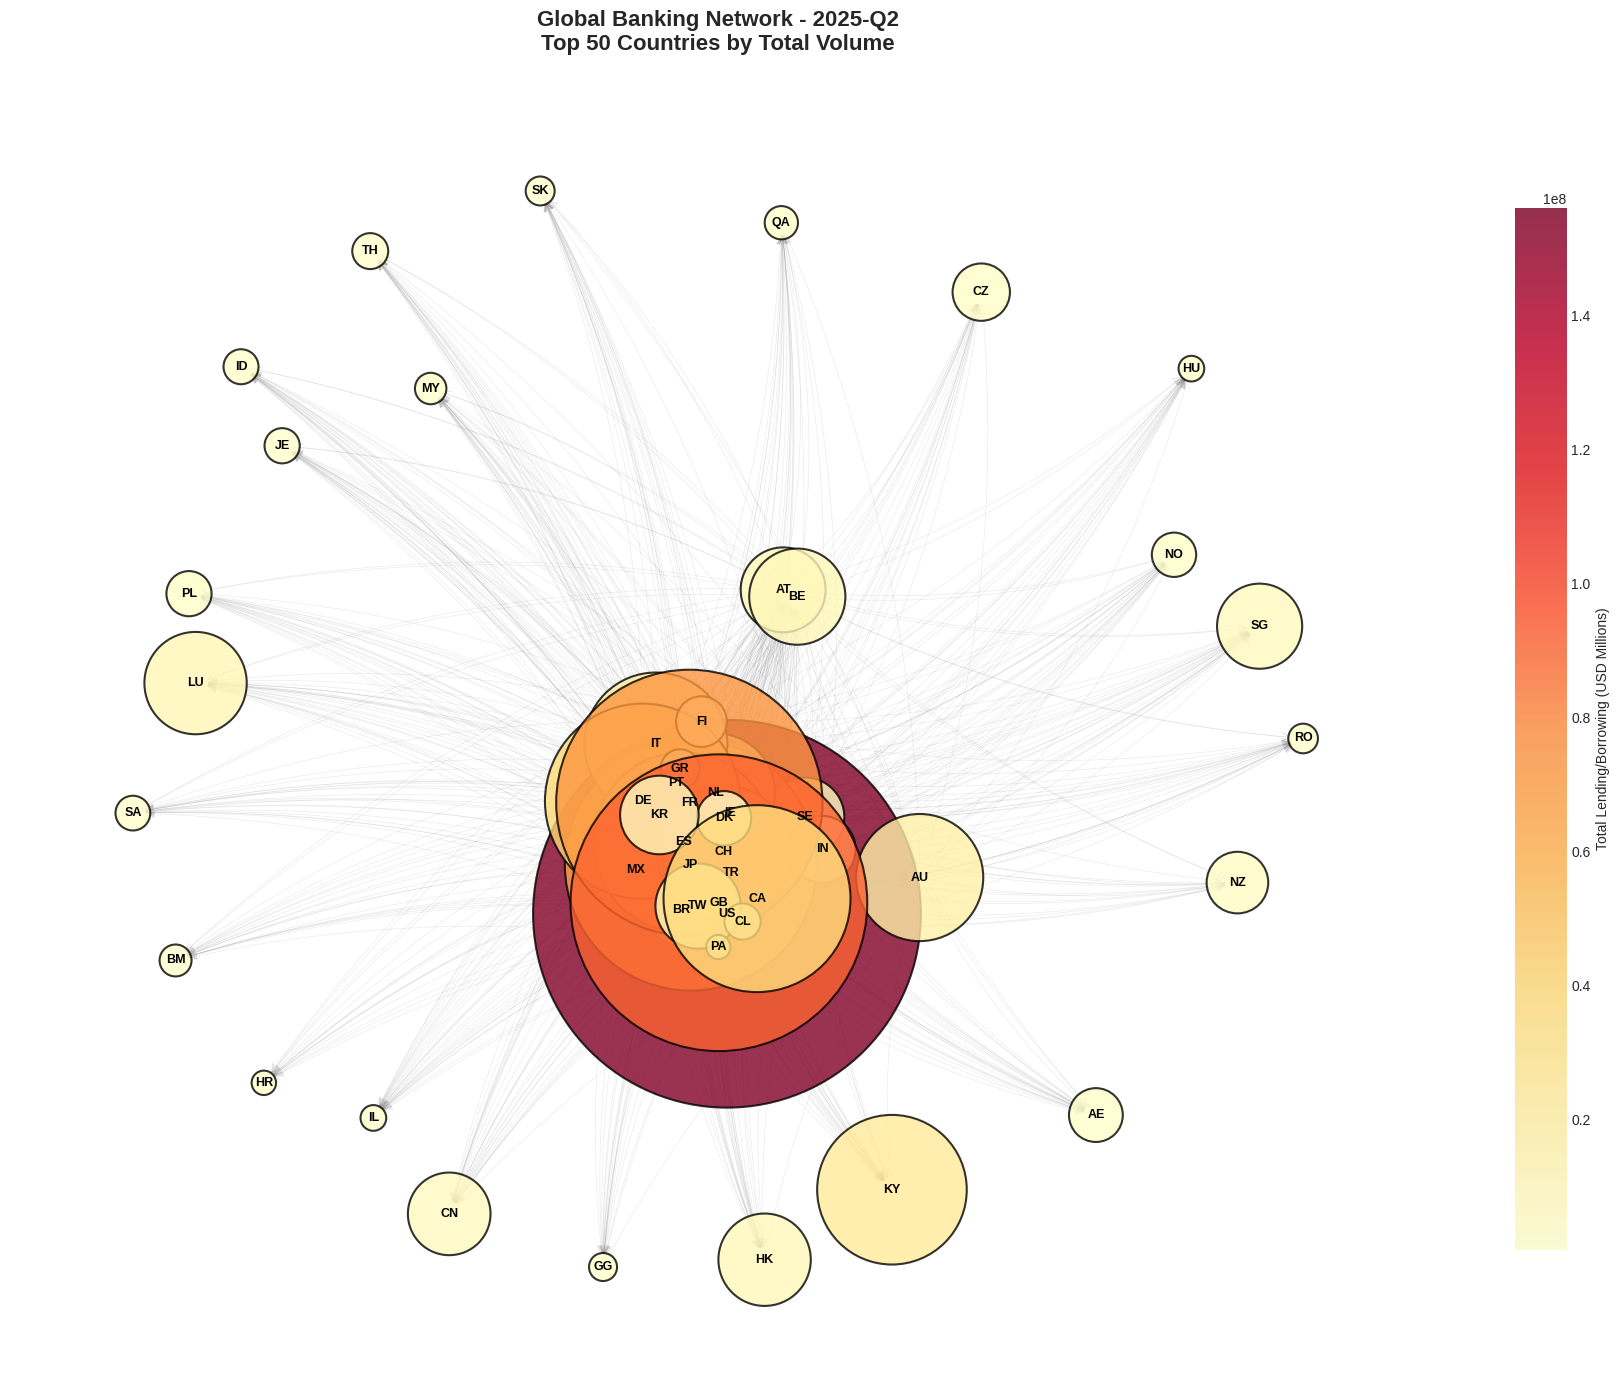

 Visualization saved


In [17]:
fig, ax = plt.subplots(figsize=(18, 14))

# Top 50 nodes by total strength
in_str = dict(G.in_degree(weight='weight'))
out_str = dict(G.out_degree(weight='weight'))
total_strength = {n: in_str.get(n, 0) + out_str.get(n, 0) for n in G.nodes()}
top_nodes = sorted(total_strength.items(), key=lambda x: x[1], reverse=True)[:50]
top_node_ids = [n[0] for n in top_nodes]

G_sub = G.subgraph(top_node_ids)

# Node sizes
node_sizes = [total_strength[n] / 2000 for n in G_sub.nodes()]

# Node colors by strength
node_colors = [total_strength[n] for n in G_sub.nodes()]

# Layout
pos = nx.spring_layout(G_sub, k=3, iterations=50, seed=42)

# Draw
nodes = nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, 
                               node_color=node_colors, alpha=0.8,
                               cmap='YlOrRd', edgecolors='black', linewidths=1.5)

nx.draw_networkx_edges(G_sub, pos, alpha=0.15, arrows=True, 
                      arrowsize=15, edge_color='gray', width=0.5,
                      arrowstyle='->', connectionstyle='arc3,rad=0.1')

nx.draw_networkx_labels(G_sub, pos, font_size=9, font_weight='bold')

# Colorbar
plt.colorbar(nodes, label='Total Lending/Borrowing (USD Millions)', shrink=0.8)

plt.title(f'Global Banking Network - {selected_quarter}\nTop 50 Countries by Total Volume', 
         fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/network_viz_1.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualization saved")

In [18]:
# Save files
df_centrality.to_csv('/home/aryan/Graph_ML/centrality_results_1.csv', index=False)
nx.write_graphml(G, '/home/aryan/Graph_ML/network_1.graphml')

print("=" * 60)
print("FILES SAVED")
print("=" * 60)
print(" /home/aryan/Graph_ML/bis_clean.csv")
print(" /home/aryan/Graph_ML/centrality_results_1.csv")
print(" /home/aryan/Graph_ML/network_1.graphml")
print(" /home/aryan/Graph_ML/network_viz_1.png")

FILES SAVED
 /home/aryan/Graph_ML/bis_clean.csv
 /home/aryan/Graph_ML/centrality_results_1.csv
 /home/aryan/Graph_ML/network_1.graphml
 /home/aryan/Graph_ML/network_viz_1.png


In [26]:
print("=" * 80)
print("DETAILED COMPONENT ANALYSIS")
print("=" * 80)

# Get all components
wcc_list = list(nx.weakly_connected_components(G))
scc_list = list(nx.strongly_connected_components(G))

# Largest SCC (mutual traders - the core)
largest_scc = max(scc_list, key=len)
print(f"\n{'='*80}")
print(f"CORE TRADING GROUP (Largest SCC) - {len(largest_scc)} countries")
print(f"{'='*80}")
print("These countries both lend to AND borrow from each other:\n")
print(sorted(list(largest_scc)))

# Calculate IN and OUT components
in_component = set()
out_component = set()
tendrils = set()

for node in G.nodes():
    if node in largest_scc:
        continue
    
    # Can reach SCC?
    can_reach_scc = False
    for scc_node in list(largest_scc)[:5]:  # Sample for speed
        if nx.has_path(G, node, scc_node):
            can_reach_scc = True
            break
    
    # Reachable from SCC?
    reachable_from_scc = False
    for scc_node in list(largest_scc)[:5]:
        if nx.has_path(G, scc_node, node):
            reachable_from_scc = True
            break
    
    if can_reach_scc and not reachable_from_scc:
        in_component.add(node)
    elif reachable_from_scc and not can_reach_scc:
        out_component.add(node)
    else:
        tendrils.add(node)

# Display results
print(f"\n{'='*80}")
print(f"IN COMPONENT (Pure Lenders) - {len(in_component)} countries")
print(f"{'='*80}")
print("Only lend money, don't borrow:\n")
print(sorted(list(in_component))[:20])  # Show first 20

print(f"\n{'='*80}")
print(f"OUT COMPONENT (Pure Borrowers) - {len(out_component)} countries")
print(f"{'='*80}")
print("Only borrow money, don't lend:\n")
print(sorted(list(out_component))[:20])

print(f"\n{'='*80}")
print(f"TENDRILS/DISCONNECTED - {len(tendrils)} countries")
print(f"{'='*80}")
print(sorted(list(tendrils))[:20])




# Save component assignments
component_df = pd.DataFrame({
    'Country': list(G.nodes()),
    'Component': ['SCC' if n in largest_scc else 
                  'IN' if n in in_component else 
                  'OUT' if n in out_component else 
                  'Tendril' for n in G.nodes()],
    'In_Degree': [G.in_degree(n) for n in G.nodes()],
    'Out_Degree': [G.out_degree(n) for n in G.nodes()]
})

component_df.to_csv('/home/aryan/Graph_ML/component_assignments_1.csv', index=False)
print("\n Component assignments saved to component_assignments_1.csv")

DETAILED COMPONENT ANALYSIS

CORE TRADING GROUP (Largest SCC) - 27 countries
These countries both lend to AND borrow from each other:

['AT', 'AU', 'BE', 'BR', 'CA', 'CH', 'CL', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'IE', 'IN', 'IT', 'JP', 'KR', 'MX', 'NL', 'PA', 'PT', 'SE', 'TR', 'TW', 'US']

IN COMPONENT (Pure Lenders) - 0 countries
Only lend money, don't borrow:

[]

OUT COMPONENT (Pure Borrowers) - 190 countries
Only borrow money, don't lend:

['AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO', 'AR', 'AW', 'AZ', 'BA', 'BB', 'BD', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BM']

TENDRILS/DISCONNECTED - 0 countries
[]

 Component assignments saved to component_assignments_1.csv


WCC vs SCC COMPONENT VISUALIZATION

 Component Analysis:
   • Weakly Connected Components (WCC): 1
   • Strongly Connected Components (SCC): 191
   • Largest WCC size: 217
   • Largest SCC size: 27

 Top 10 SCC Sizes:
   1. SCC with 27 nodes
   2. SCC with 1 nodes
   3. SCC with 1 nodes
   4. SCC with 1 nodes
   5. SCC with 1 nodes
   6. SCC with 1 nodes
   7. SCC with 1 nodes
   8. SCC with 1 nodes
   9. SCC with 1 nodes
   10. SCC with 1 nodes

 Creating WCC visualization...
 Creating SCC visualization...


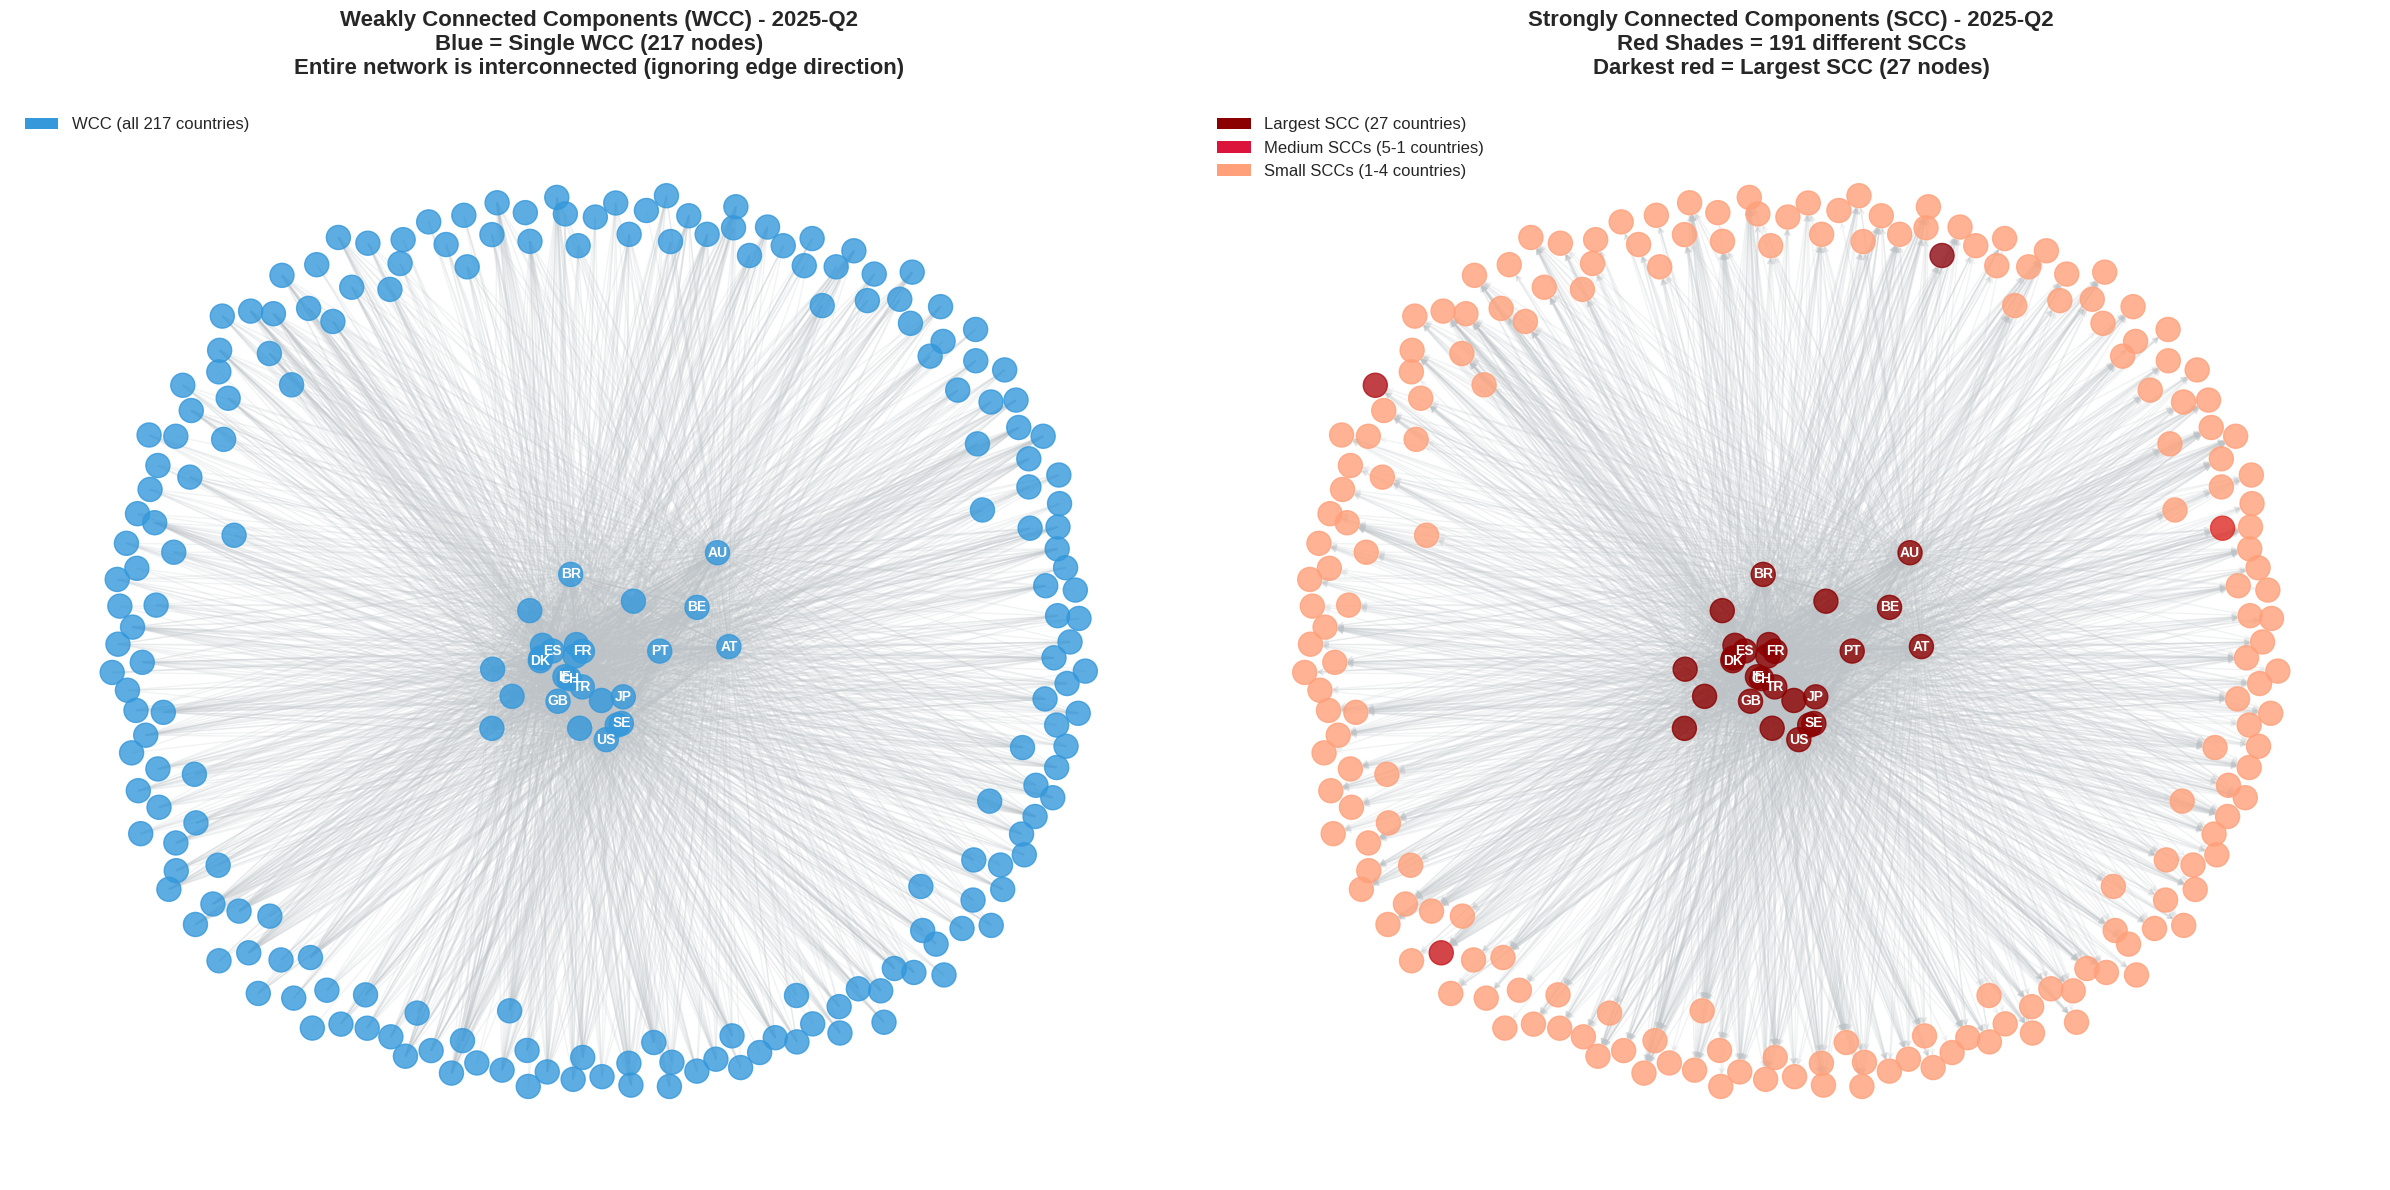


 WCC vs SCC Visualization Complete!

 Key Insight:
   • WCC = 1 → Network is fully connected (ignoring direction)
   • SCC = 191 → But 191 separate strongly connected clusters
   • This shows the network has clear hierarchical structure!


In [30]:
# ========================================================================
# WCC vs SCC VISUALIZATION
# Blue = Single WCC (entire network connected)
# Red shades = Multiple SCCs (strongly connected subgraphs)
# ========================================================================

print("=" * 80)
print("WCC vs SCC COMPONENT VISUALIZATION")
print("=" * 80)

# Get all components
all_sccs = list(nx.strongly_connected_components(G))
all_wccs = list(nx.weakly_connected_components(G))

print(f"\n Component Analysis:")
print(f"   • Weakly Connected Components (WCC): {len(all_wccs)}")
print(f"   • Strongly Connected Components (SCC): {len(all_sccs)}")
print(f"   • Largest WCC size: {len(all_wccs[0])}")
print(f"   • Largest SCC size: {len(largest_scc)}")

# Sort SCCs by size
sccs_sorted = sorted(all_sccs, key=len, reverse=True)
print(f"\n Top 10 SCC Sizes:")
for i, scc in enumerate(sccs_sorted[:10]):
    print(f"   {i+1}. SCC with {len(scc)} nodes")

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# ========== LEFT PLOT: WCC (Single Component in Blue) ==========
print("\n Creating WCC visualization...")

# Use spring layout for better separation
pos_wcc = nx.spring_layout(G, k=3, iterations=50, seed=42)

# All nodes are in one WCC, color them blue
node_colors_wcc = ['#3498db' for _ in G.nodes()]

# Draw WCC network
nx.draw_networkx_nodes(G, pos_wcc, node_color=node_colors_wcc, 
                       node_size=300, alpha=0.8, ax=ax1)
nx.draw_networkx_edges(G, pos_wcc, edge_color='#bdc3c7', 
                       alpha=0.2, arrows=False, ax=ax1)

# Label top 15 countries by degree
top_countries = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:15]
labels_wcc = {node: node for node, _ in top_countries}
nx.draw_networkx_labels(G, pos_wcc, labels_wcc, font_size=10, 
                        font_weight='bold', font_color='white', ax=ax1)

ax1.set_title(f'Weakly Connected Components (WCC) - {selected_quarter}\n'
              f'Blue = Single WCC ({G.number_of_nodes()} nodes)\n'
              f'Entire network is interconnected (ignoring edge direction)',
              fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')

# Add legend
from matplotlib.patches import Patch
wcc_legend = [Patch(facecolor='#3498db', label=f'WCC (all {G.number_of_nodes()} countries)')]
ax1.legend(handles=wcc_legend, loc='upper left', fontsize=12, framealpha=0.9)

# ========== RIGHT PLOT: SCCs (Multiple Components in Red Shades) ==========
print(" Creating SCC visualization...")

# Assign colors to SCCs - largest is darkest red, smaller ones lighter
# Generate color palette from dark red to light red
scc_colors = []
n_sccs = len(sccs_sorted)

# Map each node to its SCC color
node_to_scc_color = {}
for idx, scc in enumerate(sccs_sorted):
    # Color intensity based on size and rank
    if idx == 0:  # Largest SCC - darkest red
        color = '#8B0000'  # Dark red
    elif idx < 5:  # Top 5 SCCs - medium red shades
        intensity = 0.3 + (idx / 5) * 0.4  # 0.3 to 0.7
        color = plt.cm.Reds(intensity + 0.3)
    else:  # Smaller SCCs - lighter reds
        color = '#FFA07A'  # Light salmon
    
    for node in scc:
        node_to_scc_color[node] = color

# Create color list in node order
node_colors_scc = [node_to_scc_color[node] for node in G.nodes()]

# Use same layout for comparison
pos_scc = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Draw SCC network
nx.draw_networkx_nodes(G, pos_scc, node_color=node_colors_scc, 
                       node_size=300, alpha=0.8, ax=ax2)
nx.draw_networkx_edges(G, pos_scc, edge_color='#bdc3c7', 
                       alpha=0.2, arrows=True, arrowsize=8, 
                       arrowstyle='->', ax=ax2)

# Label top 15 countries
nx.draw_networkx_labels(G, pos_scc, labels_wcc, font_size=10, 
                        font_weight='bold', font_color='white', ax=ax2)

ax2.set_title(f'Strongly Connected Components (SCC) - {selected_quarter}\n'
              f'Red Shades = {len(sccs_sorted)} different SCCs\n'
              f'Darkest red = Largest SCC ({len(sccs_sorted[0])} nodes)',
              fontsize=16, fontweight='bold', pad=20)
ax2.axis('off')

# Add legend for SCCs
scc_legend_items = [
    Patch(facecolor='#8B0000', label=f'Largest SCC ({len(sccs_sorted[0])} countries)'),
    Patch(facecolor='#DC143C', label=f'Medium SCCs (5-{len(sccs_sorted[4]) if len(sccs_sorted) > 4 else "N/A"} countries)'),
    Patch(facecolor='#FFA07A', label=f'Small SCCs (1-4 countries)')
]
ax2.legend(handles=scc_legend_items, loc='upper left', fontsize=12, framealpha=0.9)

plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/wcc_vs_scc_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print(" WCC vs SCC Visualization Complete!")
print("=" * 80)
print("\n Key Insight:")
print(f"   • WCC = {len(all_wccs)} → Network is fully connected (ignoring direction)")
print(f"   • SCC = {len(sccs_sorted)} → But {len(sccs_sorted)} separate strongly connected clusters")
print(f"   • This shows the network has clear hierarchical structure!")
print("=" * 80)

# Closeness and Outbreak detection

In [35]:
print("=" * 80)
print("CLOSENESS CENTRALITY TEST")
print("=" * 80)


import numpy as np
from scipy.stats import spearmanr, kendalltau
import networkx as nx
import pandas as pd

# Step 1: Calculate Closeness Centrality for all nodes
print("\n" + "=" * 80)
print("STEP 1: CALCULATE CLOSENESS CENTRALITY")
print("=" * 80)

# Closeness centrality 
print("\nCalculating closeness centrality...")
print("(For directed networks, uses out-closeness by default)")

try:
    # For directed graphs, calculate out-closeness (how quickly node can reach others)
    closeness = nx.closeness_centrality(G, distance='weight')
    print(" Closeness centrality calculated")
except:
    # If graph is not strongly connected, calculate for largest component
    print(" Full graph not strongly connected, calculating for largest WCC...")
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G_wcc = G.subgraph(largest_wcc)
    closeness = nx.closeness_centrality(G_wcc, distance='weight')
    
    # Add zeros for nodes not in WCC
    for node in G.nodes():
        if node not in closeness:
            closeness[node] = 0
    print(" Closeness centrality calculated for largest component")

# Create DataFrame
df_closeness = pd.DataFrame({
    'Country': list(closeness.keys()),
    'Closeness': list(closeness.values())
})
df_closeness = df_closeness.sort_values('Closeness', ascending=False)

# Display top 15 by closeness
print("\n" + "=" * 80)
print("TOP 15 COUNTRIES BY CLOSENESS CENTRALITY")
print("=" * 80)
print("\nCloseness = How quickly a country can reach all others in the network")
print("Higher closeness = More central position\n")

for i, (idx, row) in enumerate(df_closeness.head(15).iterrows(), 1):
    print(f"  {i:2d}. {row['Country']:3s}  {row['Closeness']:.6f}")

# Save
df_closeness.to_csv('/home/aryan/Graph_ML/closeness_centrality_1.csv', index=False)
print("\n Closeness centrality saved to closeness_centrality_1.csv")

CLOSENESS CENTRALITY TEST

STEP 1: CALCULATE CLOSENESS CENTRALITY

Calculating closeness centrality...
(For directed networks, uses out-closeness by default)
 Closeness centrality calculated

TOP 15 COUNTRIES BY CLOSENESS CENTRALITY

Closeness = How quickly a country can reach all others in the network
Higher closeness = More central position

   1. LV   0.000260
   2. EE   0.000259
   3. IR   0.000216
   4. FJ   0.000197
   5. AL   0.000192
   6. JM   0.000188
   7. IS   0.000182
   8. ET   0.000179
   9. TT   0.000172
  10. AM   0.000170
  11. BG   0.000158
  12. IQ   0.000153
  13. GA   0.000141
  14. HR   0.000136
  15. YE   0.000132

 Closeness centrality saved to closeness_centrality_1.csv


In [38]:
print("=" * 80)
print("CELF OUTBREAK DETECTION IMPLEMENTATION")
print("=" * 80)
print("\nKey insight: Banking crises propagate in BOTH directions")
print("  - Forward: Lender fails → Borrowers lose funding")
print("  - Backward: Borrower defaults → Lenders lose assets")
print("\nSolution: Use UNDIRECTED network (treat edges as bidirectional)")

import numpy as np
from collections import deque

def bfs_detection_time_undirected(G_undirected, source, monitors):
    """
    BFS to find shortest path from source to any monitor.
    Uses undirected graph (crisis can spread along OR against lending edges).
    
    Returns: detection time (hops to nearest monitor), or 999 if never detected
    """
    if source in monitors:
        return 0
    
    visited = {source}
    queue = deque([(source, 0)])
    
    while queue:
        node, dist = queue.popleft()
        
        # Check neighbors in UNDIRECTED graph
        for neighbor in G_undirected.neighbors(node):
            if neighbor in monitors:
                return dist + 1
            
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, dist + 1))
    
    # Never reaches a monitor (isolated component)
    return 999

def evaluate_monitor_set(G_undirected, monitors, node_weights=None):
    """
    Evaluate a set of monitors by calculating weighted expected detection time.
    
    Args:
        G_undirected: Undirected version of network
        monitors: Set of monitor node IDs
        node_weights: Dict of {node: weight} for outbreak probabilities
                      If None, uses uniform probability
    
    Returns: Weighted sum of detection times
    """
    if node_weights is None:
        # Uniform probability
        node_weights = {n: 1.0 / G_undirected.number_of_nodes() 
                       for n in G_undirected.nodes()}
    
    total_penalty = 0.0
    
    for source, weight in node_weights.items():
        detection_time = bfs_detection_time_undirected(G_undirected, source, monitors)
        total_penalty += weight * detection_time
    
    return total_penalty

def celf_greedy_monitors(G_undirected, k_max=15, weight_by_importance=True):
    """
    CELF (Cost-Effective Lazy Forward-selection) algorithm for monitor placement.
    
    Args:
        G_undirected: Undirected network
        k_max: Maximum number of monitors
        weight_by_importance: If True, weight outbreak probability by node volume
    
    Returns: DataFrame with monitor selections and penalties
    """
    
    # Calculate node importance weights
    if weight_by_importance:
        # Use original directed graph to get strengths
        in_str = dict(G.in_degree(weight='weight'))
        out_str = dict(G.out_degree(weight='weight'))
        total_strength = {n: in_str.get(n, 0) + out_str.get(n, 0) 
                         for n in G_undirected.nodes()}
        total_weight = sum(total_strength.values())
        
        # Normalize to probabilities
        node_weights = {n: total_strength[n] / total_weight 
                       for n in G_undirected.nodes()}
        
        # Show top crisis sources
        top_sources = sorted(total_strength.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\nTop 10 weighted crisis sources:")
        for i, (node, strength) in enumerate(top_sources, 1):
            prob = node_weights[node] * 100
            print(f"  {i:2}. {node}: ${strength:>12,.0f}M ({prob:.2f}% weight)")
    else:
        # Uniform weights
        node_weights = None
        print("\nUsing uniform outbreak probability across all nodes")
    
    # CELF data structure: track marginal gains
    # marginal_gain[node] = reduction in penalty if we add this node next
    marginal_gains = {}
    
    # Current monitor set
    monitors = set()
    results = []
    
    # Initial evaluation: marginal gain of each node as first monitor
    print("\n" + "=" * 80)
    print("CELF GREEDY SELECTION")
    print("=" * 80)
    print("\nInitializing: calculating marginal gain for each candidate...")
    
    baseline_penalty = evaluate_monitor_set(G_undirected, monitors, node_weights)
    print(f"Baseline penalty (no monitors): {baseline_penalty:.4f}")
    
    for node in G_undirected.nodes():
        penalty_with_node = evaluate_monitor_set(G_undirected, {node}, node_weights)
        marginal_gains[node] = baseline_penalty - penalty_with_node
    
    # Sort by marginal gain (lazy evaluation will update these as needed)
    sorted_gains = sorted(marginal_gains.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 5 candidates by initial marginal gain:")
    for i, (node, gain) in enumerate(sorted_gains[:5], 1):
        print(f"  {i}. {node}: {gain:.4f} reduction")
    
    # Greedy selection with lazy evaluation
    for k in range(1, k_max + 1):
        print(f"\n--- Selecting monitor #{k} ---")
        
        # Current best candidate
        best_candidate = None
        best_gain = -1
        rechecked = 0
        
        # Iterate through candidates sorted by marginal gain
        while sorted_gains:
            candidate, old_gain = sorted_gains[0]
            
            # Skip if already selected
            if candidate in monitors:
                sorted_gains.pop(0)
                continue
            
            # If this candidate's gain is already the best and was recently updated, pick it
            # Otherwise, recompute its marginal gain (lazy evaluation)
            test_monitors = monitors | {candidate}
            current_penalty = evaluate_monitor_set(G_undirected, monitors, node_weights)
            new_penalty = evaluate_monitor_set(G_undirected, test_monitors, node_weights)
            actual_gain = current_penalty - new_penalty
            
            # Update marginal gain
            marginal_gains[candidate] = actual_gain
            rechecked += 1
            
            # If this gain is still best, select it
            if actual_gain >= best_gain:
                best_candidate = candidate
                best_gain = actual_gain
                # Remove from sorted list and reinsert at correct position
                sorted_gains.pop(0)
                break
            else:
                # This candidate's gain decreased; resort
                sorted_gains.pop(0)
                # Reinsert at correct position
                for i, (n, g) in enumerate(sorted_gains):
                    if actual_gain > g:
                        sorted_gains.insert(i, (candidate, actual_gain))
                        break
                else:
                    sorted_gains.append((candidate, actual_gain))
        
        if best_candidate is None:
            print(f"No more candidates available")
            break
        
        # Add best candidate to monitor set
        monitors.add(best_candidate)
        new_penalty = evaluate_monitor_set(G_undirected, monitors, node_weights)
        
        # Get node characteristics
        node_degree = G_undirected.degree(best_candidate)
        node_strength_in = in_str.get(best_candidate, 0)
        node_strength_out = out_str.get(best_candidate, 0)
        node_strength_total = node_strength_in + node_strength_out
        
        results.append({
            'k': k,
            'monitor': best_candidate,
            'penalty': new_penalty,
            'marginal_gain': best_gain,
            'degree': node_degree,
            'strength_in_M': node_strength_in,
            'strength_out_M': node_strength_out,
            'strength_total_M': node_strength_total,
            'rechecked': rechecked
        })
        
        print(f"Selected: {best_candidate}")
        print(f"  Degree (undirected): {node_degree}")
        print(f"  Total strength: ${node_strength_total:,.0f}M")
        print(f"  Marginal gain: {best_gain:.4f}")
        print(f"  New penalty: {new_penalty:.4f}")
        print(f"  (Lazy evaluations: {rechecked})")
    
    return pd.DataFrame(results), monitors

# Create undirected version of network
print("\nConverting network to undirected (crisis can spread both ways)...")
G_undirected = G.to_undirected()
print(f"Original: {G.number_of_nodes()} nodes, {G.number_of_edges()} directed edges")
print(f"Undirected: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")

# Run CELF algorithm
print("Using weighted outbreak probabilities (importance-based)\n")

df_monitors, optimal_monitors = celf_greedy_monitors(G_undirected, k_max=15, weight_by_importance=True)

# Display results
print("\n" + "=" * 80)
print("OPTIMAL MONITOR PLACEMENT - FINAL RESULTS")
print("=" * 80)

print(f"\n{'Rank':<6} {'Monitor':<10} {'Degree':<8} {'Strength ($M)':<18} {'Marginal Gain':<15} {'Penalty':<12}")
print("-" * 85)

for i, (idx, row) in enumerate(df_monitors.iterrows(), 1):
    print(f"{i:<6} {row['monitor']:<10} {row['degree']:<8} ${row['strength_total_M']:<17,.0f} {row['marginal_gain']:<15.4f} {row['penalty']:<12.4f}")

# Calculate total improvement
initial_penalty = evaluate_monitor_set(G_undirected, set(), 
                                      {n: 1.0/G_undirected.number_of_nodes() for n in G_undirected.nodes()})
final_penalty = df_monitors.iloc[-1]['penalty']
total_improvement = initial_penalty - final_penalty
pct_improvement = (total_improvement / initial_penalty) * 100

print("\n" + "=" * 80)
print("PERFORMANCE SUMMARY")
print("=" * 80)
print(f"Initial penalty (no monitors): {initial_penalty:.4f}")
print(f"Final penalty (15 monitors):   {final_penalty:.4f}")
print(f"Total improvement:             {total_improvement:.4f} ({pct_improvement:.2f}%)")
print(f"Average detection time:        {final_penalty:.2f} hops")

# Save results
df_monitors.to_csv('/home/aryan/Graph_ML/optimal_monitors_celf_correct.csv', index=False)
print("\n Results saved to optimal_monitors_celf_correct.csv")

# Show which nodes are covered well vs poorly
print("\n" + "=" * 80)
print("COVERAGE ANALYSIS")
print("=" * 80)

# Calculate detection time from each important node
in_str = dict(G.in_degree(weight='weight'))
out_str = dict(G.out_degree(weight='weight'))
total_strength = {n: in_str.get(n, 0) + out_str.get(n, 0) for n in G_undirected.nodes()}
top_nodes = sorted(total_strength.items(), key=lambda x: x[1], reverse=True)[:20]

print("\nDetection time from top 20 most important countries:")
print(f"{'Rank':<6} {'Country':<10} {'Strength ($M)':<18} {'Detection Time':<15}")
print("-" * 55)

for i, (node, strength) in enumerate(top_nodes, 1):
    det_time = bfs_detection_time_undirected(G_undirected, node, optimal_monitors)
    if det_time == 999:
        det_str = "NEVER"
    elif det_time == 0:
        det_str = "0 (monitored)"
    else:
        det_str = f"{det_time} hops"
    print(f"{i:<6} {node:<10} ${strength:<17,.0f} {det_str:<15}")

print("\n CELF ALGORITHM COMPLETE")


CELF OUTBREAK DETECTION IMPLEMENTATION

Key insight: Banking crises propagate in BOTH directions
  - Forward: Lender fails → Borrowers lose funding
  - Backward: Borrower defaults → Lenders lose assets

Solution: Use UNDIRECTED network (treat edges as bidirectional)

Converting network to undirected (crisis can spread both ways)...
Original: 217 nodes, 2849 directed edges
Undirected: 217 nodes, 2546 edges
Using weighted outbreak probabilities (importance-based)


Top 10 weighted crisis sources:
   1. US: $ 155,960,853M (21.16% weight)
   2. GB: $  91,289,508M (12.39% weight)
   3. FR: $  73,527,751M (9.98% weight)
   4. JP: $  65,751,768M (8.92% weight)
   5. DE: $  39,565,486M (5.37% weight)
   6. CA: $  36,234,235M (4.92% weight)
   7. ES: $  33,544,633M (4.55% weight)
   8. KY: $  23,205,437M (3.15% weight)
   9. IT: $  21,250,135M (2.88% weight)
  10. CH: $  18,686,001M (2.54% weight)

CELF GREEDY SELECTION

Initializing: calculating marginal gain for each candidate...
Baseline pen

# Louvain Community Detection

In [ ]:


print("=" * 80)
print("COMMUNITY DETECTION - TRADING BLOCS (LOUVAIN ALGORITHM)")
print("=" * 80)

import community.community_louvain as community_louvain

# Convert to undirected (community detection works on undirected networks)
print("\nConverting to undirected network...")
G_undirected = G.to_undirected()

# Louvain algorithm - finds communities with best modularity
print("Running Louvain algorithm...")
partition = community_louvain.best_partition(G_undirected, weight='weight', random_state=42)

# Calculate modularity
modularity = community_louvain.modularity(partition, G_undirected, weight='weight')

num_communities = len(set(partition.values()))
print(f"\n Found {num_communities} trading communities")
print(f"  Modularity score: {modularity:.4f}")
print(f"  (Modularity > 0.3 indicates strong community structure)")

# Organize communities
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Sort by size
communities_sorted = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

print("\n" + "=" * 80)
print("DETECTED TRADING COMMUNITIES")
print("=" * 80)

# Display each community with analysis
for rank, (comm_id, members) in enumerate(communities_sorted, 1):
    print(f"\n{'='*80}")
    print(f"Community {rank} (ID: {comm_id}) - {len(members)} countries")
    print(f"{'='*80}")
    
    # Calculate community stats
    community_volume = 0
    for node in members:
        if node in G.nodes():
            in_str = dict(G.in_degree(weight='weight'))
            out_str = dict(G.out_degree(weight='weight'))
            community_volume += in_str.get(node, 0) + out_str.get(node, 0)
    
    print(f"Total volume: ${community_volume:,.0f}M")
    print(f"Members: {sorted(members)}")
    
    # Identify major players in this community
    member_strengths = {}
    for node in members:
        if node in G.nodes():
            in_str = dict(G.in_degree(weight='weight'))
            out_str = dict(G.out_degree(weight='weight'))
            total = in_str.get(node, 0) + out_str.get(node, 0)
            member_strengths[node] = total
    
    top_5 = sorted(member_strengths.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Top 5 by volume:")
    for country, volume in top_5:
        print(f"  {country}: ${volume:>12,.0f}M")

# Analyze community composition by geography
print("\n" + "=" * 80)
print("GEOGRAPHIC ANALYSIS OF COMMUNITIES")
print("=" * 80)

# Define regions
regions_map = {
    'North America': ['US', 'CA', 'MX'],
    'Europe': ['GB', 'FR', 'DE', 'IT', 'ES', 'NL', 'BE', 'AT', 'SE', 'DK', 'NO', 'FI', 
               'IE', 'PT', 'GR', 'CH', 'PL', 'CZ', 'HU', 'RO', 'BG', 'HR', 'SI', 'SK',
               'LT', 'LV', 'EE', 'LU', 'MT', 'CY'],
    'Asia-Pacific': ['JP', 'CN', 'KR', 'IN', 'SG', 'HK', 'TW', 'TH', 'ID', 'MY', 'PH', 
                     'VN', 'AU', 'NZ', 'BD', 'PK', 'KH', 'LA', 'MM', 'BN'],
    'Middle East': ['AE', 'SA', 'IL', 'QA', 'KW', 'BH', 'TR', 'OM', 'JO', 'LB'],
    'Latin America': ['BR', 'AR', 'CL', 'CO', 'PE', 'VE', 'PA', 'UY', 'EC', 'BO', 'PY'],
    'Africa': ['ZA', 'EG', 'NG', 'KE', 'MA', 'TN', 'GH', 'ET', 'UG', 'TZ', 'AO', 'DZ'],
    'Offshore Centers': ['KY', 'BM', 'BS', 'JE', 'GG', 'IM', 'VG']
}

# Reverse mapping
country_to_region = {}
for region, countries in regions_map.items():
    for country in countries:
        country_to_region[country] = region

for rank, (comm_id, members) in enumerate(communities_sorted, 1):
    print(f"\nCommunity {rank} - Regional Composition:")
    
    region_counts = {}
    for member in members:
        region = country_to_region.get(member, 'Other')
        region_counts[region] = region_counts.get(region, 0) + 1
    
    for region, count in sorted(region_counts.items(), key=lambda x: x[1], reverse=True):
        pct = (count / len(members)) * 100
        print(f"  {region:20s}: {count:3d} countries ({pct:5.1f}%)")

# Save community assignments
community_df = pd.DataFrame({
    'Country': list(partition.keys()),
    'Community_ID': list(partition.values())
})

# Add region and volume info
community_df['Region'] = community_df['Country'].map(country_to_region).fillna('Other')

# Add total strength
total_strength_dict = {}
in_str = dict(G.in_degree(weight='weight'))
out_str = dict(G.out_degree(weight='weight'))
for node in G.nodes():
    total_strength_dict[node] = in_str.get(node, 0) + out_str.get(node, 0)

community_df['Total_Strength_M'] = community_df['Country'].map(total_strength_dict).fillna(0)

# Sort by community size, then by strength
community_sizes = community_df['Community_ID'].value_counts()
community_df['Community_Size'] = community_df['Community_ID'].map(community_sizes)
community_df = community_df.sort_values(['Community_Size', 'Total_Strength_M'], 
                                        ascending=[False, False])

community_df.to_csv('/home/aryan/Graph_ML/community_assignments_louvain_1.csv', index=False)
print("\n Community assignments saved to community_assignments_louvain_1.csv")


VISUALIZING TRADING COMMUNITIES


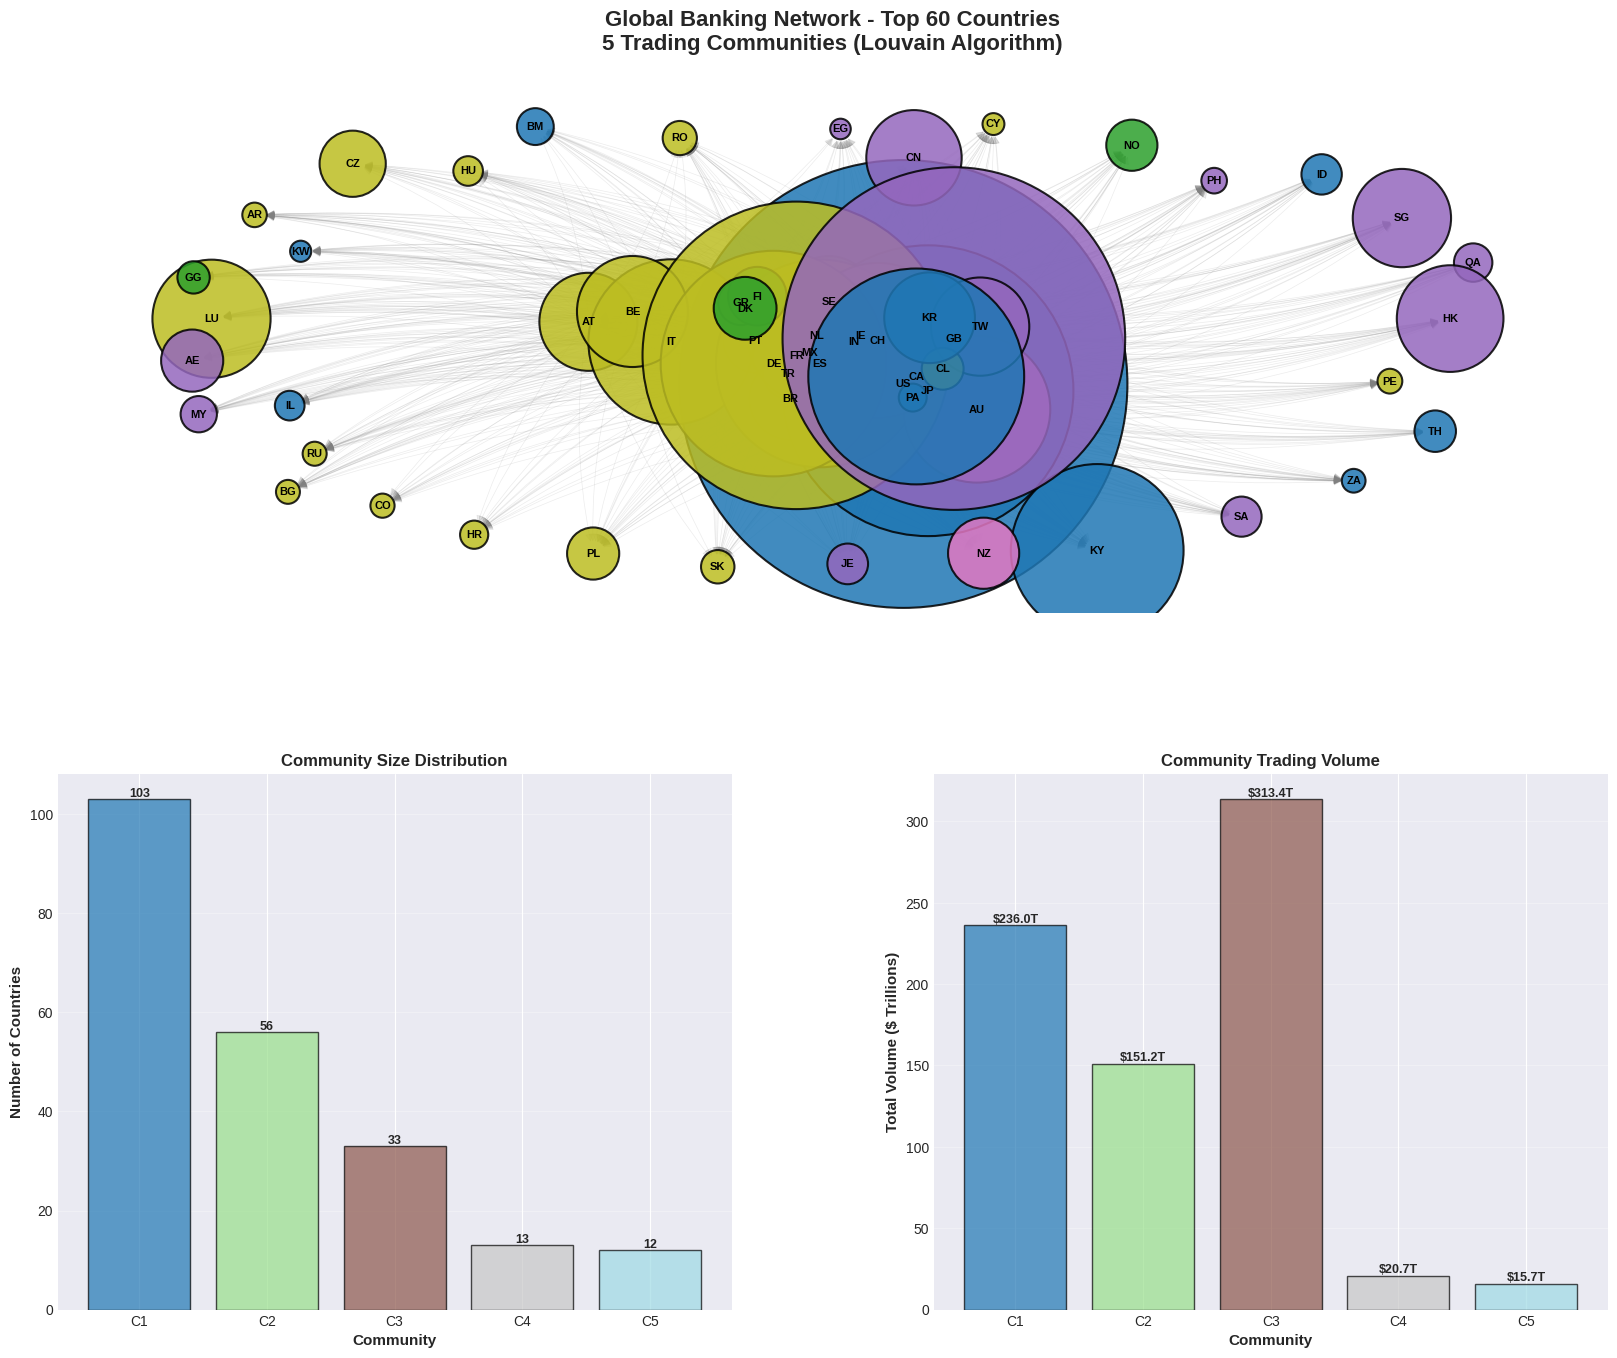

 Visualization saved to community_detection_louvain_1.png


In [22]:
print("\n" + "=" * 80)
print("VISUALIZING TRADING COMMUNITIES")
print("=" * 80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Full network with communities (top 60 nodes)
ax1 = fig.add_subplot(gs[0, :])

top_nodes = sorted(total_strength_dict.items(), key=lambda x: x[1], reverse=True)[:60]
top_node_ids = [n[0] for n in top_nodes]
G_sub = G.subgraph(top_node_ids)

# Assign colors by community
import matplotlib.cm as cm
cmap = cm.get_cmap('tab20')
num_comms = len(set(partition.values()))
colors = [cmap(partition[n] / num_comms) for n in G_sub.nodes()]

# Node sizes by total strength
node_sizes = [total_strength_dict[n] / 1500 for n in G_sub.nodes()]

# Layout
pos = nx.spring_layout(G_sub, k=3, iterations=50, seed=42)

# Draw
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes,
                      node_color=colors, alpha=0.85,
                      edgecolors='black', linewidths=1.5, ax=ax1)

nx.draw_networkx_edges(G_sub, pos, alpha=0.15, arrows=True,
                      arrowsize=12, edge_color='gray', width=0.5,
                      ax=ax1, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_labels(G_sub, pos, font_size=8, font_weight='bold', ax=ax1)

ax1.set_title(f'Global Banking Network - Top 60 Countries\n{num_communities} Trading Communities (Louvain Algorithm)', 
             fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')

# Plot 2: Community size distribution
ax2 = fig.add_subplot(gs[1, 0])

comm_sizes = [len(members) for _, members in communities_sorted]
comm_labels = [f"C{rank}" for rank, _ in enumerate(communities_sorted, 1)]

bars = ax2.bar(range(len(comm_sizes)), comm_sizes, color=cmap(np.linspace(0, 1, len(comm_sizes))), 
               alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_xticks(range(len(comm_sizes)))
ax2.set_xticklabels(comm_labels, rotation=0)
ax2.set_xlabel('Community', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Countries', fontsize=11, fontweight='bold')
ax2.set_title('Community Size Distribution', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, size) in enumerate(zip(bars, comm_sizes)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(size)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Community volume distribution
ax3 = fig.add_subplot(gs[1, 1])

comm_volumes = []
for _, members in communities_sorted:
    vol = 0
    for node in members:
        if node in G.nodes():
            vol += in_str.get(node, 0) + out_str.get(node, 0)
    comm_volumes.append(vol / 1e6)  # Convert to trillions

bars = ax3.bar(range(len(comm_volumes)), comm_volumes, 
               color=cmap(np.linspace(0, 1, len(comm_volumes))), 
               alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_xticks(range(len(comm_volumes)))
ax3.set_xticklabels(comm_labels, rotation=0)
ax3.set_xlabel('Community', fontsize=11, fontweight='bold')
ax3.set_ylabel('Total Volume ($ Trillions)', fontsize=11, fontweight='bold')
ax3.set_title('Community Trading Volume', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# Add value labels
for i, (bar, vol) in enumerate(zip(bars, comm_volumes)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'${vol:.1f}T',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.savefig('/home/aryan/Graph_ML/community_detection_louvain_1.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualization saved to community_detection_louvain_1.png")

In [23]:
print("\n" + "=" * 80)
print("COMMUNITY CHARACTERISTICS & INTERPRETATION")
print("=" * 80)

# Analyze each community's defining features
for rank, (comm_id, members) in enumerate(communities_sorted[:8], 1):  # Top 8 communities
    print(f"\n{'='*80}")
    print(f"COMMUNITY {rank} - DETAILED ANALYSIS")
    print(f"{'='*80}")
    
    # Geographic composition
    region_counts = {}
    for member in members:
        region = country_to_region.get(member, 'Other')
        region_counts[region] = region_counts.get(region, 0) + 1
    
    dominant_region = max(region_counts.items(), key=lambda x: x[1])
    
    print(f"\nSize: {len(members)} countries")
    print(f"Dominant region: {dominant_region[0]} ({dominant_region[1]} countries)")
    
    # Calculate average connectivity within community
    internal_edges = 0
    external_edges = 0
    for node in members:
        if node not in G.nodes():
            continue
        for neighbor in G.successors(node):
            if neighbor in members:
                internal_edges += 1
            else:
                external_edges += 1
    
    if internal_edges + external_edges > 0:
        internal_pct = (internal_edges / (internal_edges + external_edges)) * 100
        print(f"Internal connectivity: {internal_pct:.1f}% of edges stay within community")
    
    # Identify hub countries
    member_centrality = {}
    for node in members:
        if node in G.nodes():
            member_centrality[node] = G.degree(node)
    
    top_hubs = sorted(member_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nHub countries (most connected):")
    for country, degree in top_hubs:
        print(f"  {country}: {degree} connections")
    
    # Economic characteristics
    member_volumes = {}
    for node in members:
        if node in G.nodes():
            member_volumes[node] = total_strength_dict.get(node, 0)
    
    top_volume = sorted(member_volumes.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nLargest economies (by volume):")
    for country, volume in top_volume:
        print(f"  {country}: ${volume:>12,.0f}M")
    
    # Identify if it's a lender or borrower community
    total_out = sum(G.out_degree(n, weight='weight') for n in members if n in G.nodes())
    total_in = sum(G.in_degree(n, weight='weight') for n in members if n in G.nodes())
    
    if total_out > 0 or total_in > 0:
        net_position = total_out - total_in
        if net_position > 0:
            print(f"\nCharacter: Net LENDER community (+${net_position:,.0f}M)")
        else:
            print(f"\nCharacter: Net BORROWER community (${net_position:,.0f}M)")
    
    # Suggested name/interpretation
    print(f"\nSuggested interpretation:")
    if dominant_region[0] == 'Europe' and dominant_region[1] >= len(members) * 0.5:
        print(f"  → European Banking Bloc")
    elif dominant_region[0] == 'Asia-Pacific' and dominant_region[1] >= len(members) * 0.5:
        print(f"  → Asia-Pacific Trading Network")
    elif 'US' in members and 'CA' in members and dominant_region[0] == 'North America':
        print(f"  → North American Financial Center")
    elif dominant_region[0] == 'Offshore Centers':
        print(f"  → Offshore Financial Hub Network")
    elif 'GB' in members and 'US' in members:
        print(f"  → Anglo-American Core")
    else:
        most_prominent = top_volume[0][0] if top_volume else "Unknown"
        print(f"  → {dominant_region[0]}-centric cluster (led by {most_prominent})")

print("\n" + "=" * 80)
print("COMMUNITY ANALYSIS COMPLETE")
print("=" * 80)



COMMUNITY CHARACTERISTICS & INTERPRETATION

COMMUNITY 1 - DETAILED ANALYSIS

Size: 103 countries
Dominant region: Other (65 countries)
Internal connectivity: 47.9% of edges stay within community

Hub countries (most connected):
  FR: 218 connections
  ES: 197 connections
  AT: 196 connections

Largest economies (by volume):
  FR: $  73,527,751M
  DE: $  39,565,486M
  ES: $  33,544,633M

Character: Net LENDER community (+$25,874,287M)

Suggested interpretation:
  → Other-centric cluster (led by FR)

COMMUNITY 2 - DETAILED ANALYSIS

Size: 56 countries
Dominant region: Other (32 countries)
Internal connectivity: 26.9% of edges stay within community

Hub countries (most connected):
  CH: 222 connections
  GB: 197 connections
  TW: 82 connections

Largest economies (by volume):
  GB: $  91,289,508M
  CH: $  18,686,001M
  HK: $   8,850,182M

Character: Net LENDER community (+$10,497,438M)

Suggested interpretation:
  → Other-centric cluster (led by GB)

COMMUNITY 3 - DETAILED ANALYSIS

Size

# Temporal evolution of network

TEMPORAL NETWORK EVOLUTION

Analyzing 14 quarters: 2000-Q1 to 2025-Q2
Building networks...
 Networks built

Quarter  Nodes  Edges  Density  Avg_Clustering  Largest_SCC  Total_Volume_Trillion
2000-Q1    195   1543 0.040788        0.881903           15              40.014622
2002-Q1    201   1686 0.041940        0.845604           17              44.202457
2004-Q1    204   1902 0.045929        0.844859           22              67.797395
2006-Q1    206   2191 0.051883        0.866434           24             173.940794
2008-Q1    209   2311 0.053161        0.889210           25             294.617904
2010-Q1    210   2349 0.053520        0.863299           25             258.712703
2012-Q1    210   2480 0.056505        0.876048           28             264.306532
2014-Q1    212   3040 0.067960        0.892139           28             281.095121
2016-Q1    213   2883 0.063845        0.899696           27             252.544389
2018-Q1    213   2891 0.064022        0.880567           27   

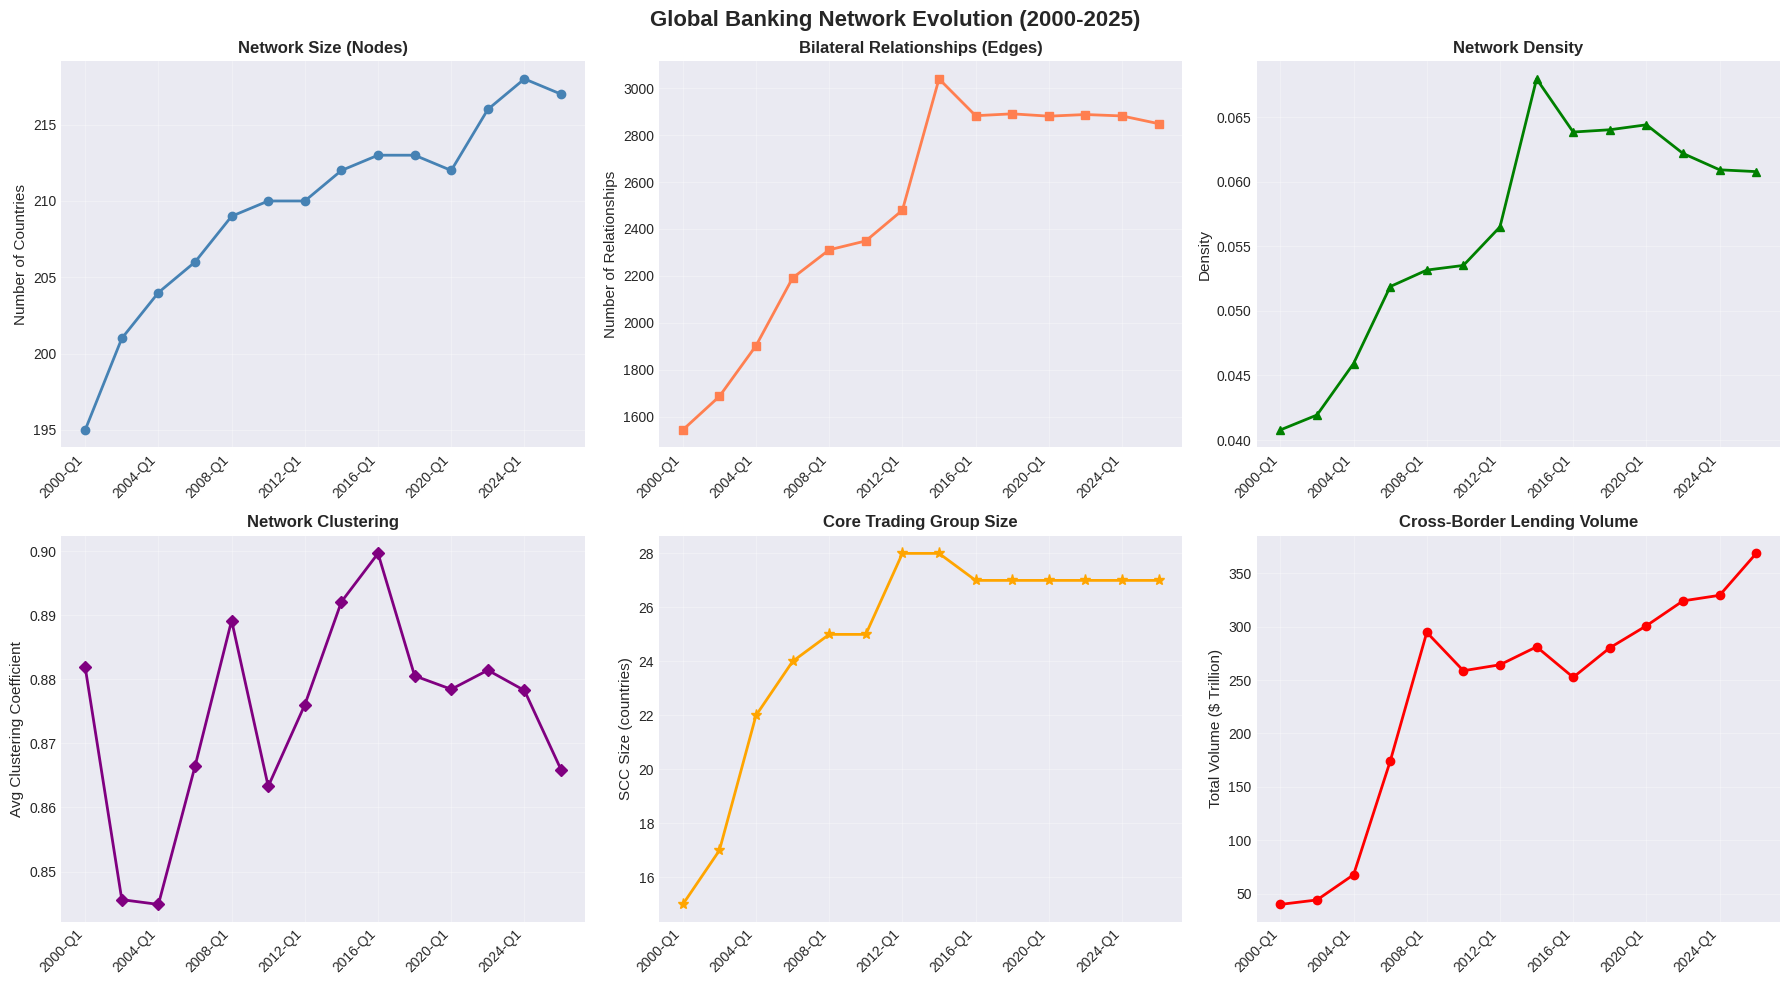


 Temporal analysis saved to temporal_stats_1.csv and temporal_evolution_1.png


In [29]:
print("=" * 80)
print("TEMPORAL NETWORK EVOLUTION")
print("=" * 80)

# Select quarters to analyze (every 2 years + latest)
all_quarters = sorted(df_clean['Quarter'].unique())
selected_quarters = []

# Pick specific years
for year in range(2000, 2026, 2):
    for q in [f'{year}-Q1', f'{year}-Q2', f'{year}-Q3', f'{year}-Q4']:
        if q in all_quarters:
            selected_quarters.append(q)
            break

# Add latest quarter if not included
if all_quarters[-1] not in selected_quarters:
    selected_quarters.append(all_quarters[-1])

print(f"\nAnalyzing {len(selected_quarters)} quarters: {selected_quarters[0]} to {selected_quarters[-1]}")
print("Building networks...")

# Build networks for each quarter
temporal_networks = {}
temporal_stats = []

for quarter in selected_quarters:
    df_q = df_clean[df_clean['Quarter'] == quarter].copy()
    
    G_q = nx.DiGraph()
    for _, row in df_q.iterrows():
        G_q.add_edge(row['L_REP_CTY'], row['L_CP_COUNTRY'], weight=row['Amount'])
    
    temporal_networks[quarter] = G_q
    
    # Calculate stats
    largest_scc = max(nx.strongly_connected_components(G_q), key=len)
    total_volume = sum(nx.get_edge_attributes(G_q, 'weight').values())
    
    stats = {
        'Quarter': quarter,
        'Nodes': G_q.number_of_nodes(),
        'Edges': G_q.number_of_edges(),
        'Density': nx.density(G_q),
        'Avg_Clustering': nx.average_clustering(G_q),
        'Largest_SCC': len(largest_scc),
        'Total_Volume_Trillion': total_volume / 1e6
    }
    temporal_stats.append(stats)

df_temporal = pd.DataFrame(temporal_stats)

print(" Networks built\n")
print(df_temporal.to_string(index=False))

# Plot temporal evolution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Global Banking Network Evolution (2000-2025)', fontsize=16, fontweight='bold')

# Plot 1: Nodes over time
axes[0, 0].plot(range(len(df_temporal)), df_temporal['Nodes'], 
                marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0, 0].set_ylabel('Number of Countries', fontsize=11)
axes[0, 0].set_title('Network Size (Nodes)', fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(range(0, len(df_temporal), 2))
axes[0, 0].set_xticklabels([df_temporal.iloc[i]['Quarter'] for i in range(0, len(df_temporal), 2)], 
                            rotation=45, ha='right')

# Plot 2: Edges over time
axes[0, 1].plot(range(len(df_temporal)), df_temporal['Edges'], 
                marker='s', linewidth=2, markersize=6, color='coral')
axes[0, 1].set_ylabel('Number of Relationships', fontsize=11)
axes[0, 1].set_title('Bilateral Relationships (Edges)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(0, len(df_temporal), 2))
axes[0, 1].set_xticklabels([df_temporal.iloc[i]['Quarter'] for i in range(0, len(df_temporal), 2)], 
                            rotation=45, ha='right')

# Plot 3: Density over time
axes[0, 2].plot(range(len(df_temporal)), df_temporal['Density'], 
                marker='^', linewidth=2, markersize=6, color='green')
axes[0, 2].set_ylabel('Density', fontsize=11)
axes[0, 2].set_title('Network Density', fontweight='bold')
axes[0, 2].grid(alpha=0.3)
axes[0, 2].set_xticks(range(0, len(df_temporal), 2))
axes[0, 2].set_xticklabels([df_temporal.iloc[i]['Quarter'] for i in range(0, len(df_temporal), 2)], 
                            rotation=45, ha='right')

# Plot 4: Clustering over time
axes[1, 0].plot(range(len(df_temporal)), df_temporal['Avg_Clustering'], 
                marker='D', linewidth=2, markersize=6, color='purple')
axes[1, 0].set_ylabel('Avg Clustering Coefficient', fontsize=11)
axes[1, 0].set_title('Network Clustering', fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(range(0, len(df_temporal), 2))
axes[1, 0].set_xticklabels([df_temporal.iloc[i]['Quarter'] for i in range(0, len(df_temporal), 2)], 
                            rotation=45, ha='right')

# Plot 5: SCC size over time
axes[1, 1].plot(range(len(df_temporal)), df_temporal['Largest_SCC'], 
                marker='*', linewidth=2, markersize=8, color='orange')
axes[1, 1].set_ylabel('SCC Size (countries)', fontsize=11)
axes[1, 1].set_title('Core Trading Group Size', fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(range(0, len(df_temporal), 2))
axes[1, 1].set_xticklabels([df_temporal.iloc[i]['Quarter'] for i in range(0, len(df_temporal), 2)], 
                            rotation=45, ha='right')

# Plot 6: Total volume over time
axes[1, 2].plot(range(len(df_temporal)), df_temporal['Total_Volume_Trillion'], 
                marker='o', linewidth=2, markersize=6, color='red')
axes[1, 2].set_ylabel('Total Volume ($ Trillion)', fontsize=11)
axes[1, 2].set_title('Cross-Border Lending Volume', fontweight='bold')
axes[1, 2].grid(alpha=0.3)
axes[1, 2].set_xticks(range(0, len(df_temporal), 2))
axes[1, 2].set_xticklabels([df_temporal.iloc[i]['Quarter'] for i in range(0, len(df_temporal), 2)], 
                            rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/temporal_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save temporal data
df_temporal.to_csv('/home/aryan/Graph_ML/temporal_stats_1.csv', index=False)
print("\n Temporal analysis saved to temporal_stats_1.csv and temporal_evolution_1.png")

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load multiple quarters of data
print("\n" + "=" * 80)
print("STEP 1: LOAD TEMPORAL DATA")
print("=" * 80)

# Define quarters to analyze (pick crisis periods + normal periods)
quarters_to_load = [
    '2007-Q4',  # Pre-crisis
    '2008-Q2',  # Crisis begins
    '2008-Q4',  # Crisis peak
    '2009-Q4',  # Recovery
    '2019-Q4',  # Pre-COVID
    '2020-Q2',  # COVID shock
    '2020-Q4',  # COVID adaptation
    '2021-Q4',  # Recovery
    '2024-Q2',  # Recent normal
    '2025-Q2',  # Latest (your current data)
]

print(f"\nAnalyzing {len(quarters_to_load)} quarters:")
for q in quarters_to_load:
    print(f"  • {q}") 

# Store current quarter
G_current = G.copy()
current_quarter = '2025-Q2'

print(f" Current quarter loaded: {current_quarter}")
print(f"  Nodes: {G_current.number_of_nodes()}")
print(f"  Edges: {G_current.number_of_edges()}")




print("\n" + "=" * 80)
print("STEP 2: NETWORK EVOLUTION METRICS")
print("=" * 80)

# Calculate key metrics for current quarter
def calculate_network_metrics(G):
    """Calculate comprehensive network statistics."""
    
    # Basic stats
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Component sizes
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    
    # Degree statistics
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    avg_in_deg = np.mean(list(in_degrees.values()))
    avg_out_deg = np.mean(list(out_degrees.values()))
    
    # Strength (weighted degree)
    in_strength = dict(G.in_degree(weight='weight'))
    out_strength = dict(G.out_degree(weight='weight'))
    total_volume = sum(in_strength.values())
    
    # Clustering
    try:
        # For directed graphs
        clustering = nx.average_clustering(G)
    except:
        clustering = 0
    
    # Reciprocity
    try:
        reciprocity = nx.reciprocity(G)
    except:
        reciprocity = 0
    
    return {
        'nodes': n_nodes,
        'edges': n_edges,
        'density': density,
        'scc_size': len(largest_scc),
        'wcc_size': len(largest_wcc),
        'avg_in_degree': avg_in_deg,
        'avg_out_degree': avg_out_deg,
        'total_volume_M': total_volume,
        'clustering': clustering,
        'reciprocity': reciprocity
    }

# Calculate for current quarter
metrics_current = calculate_network_metrics(G_current)

print("\nCurrent Quarter Network Statistics:")
print(f"{'Metric':<30} {'Value':<20}")
print("-" * 50)
print(f"{'Nodes':<30} {metrics_current['nodes']}")
print(f"{'Edges':<30} {metrics_current['edges']}")
print(f"{'Density':<30} {metrics_current['density']:.4f}")
print(f"{'Largest SCC':<30} {metrics_current['scc_size']}")
print(f"{'Largest WCC':<30} {metrics_current['wcc_size']}")
print(f"{'Avg In-Degree':<30} {metrics_current['avg_in_degree']:.2f}")
print(f"{'Avg Out-Degree':<30} {metrics_current['avg_out_degree']:.2f}")
print(f"{'Total Volume (M USD)':<30} ${metrics_current['total_volume_M']:,.0f}")
print(f"{'Clustering Coefficient':<30} {metrics_current['clustering']:.4f}")
print(f"{'Reciprocity':<30} {metrics_current['reciprocity']:.4f}")

# Create simulated evolution for visualization
# In practice, replace this with actual multi-quarter data
print("\n" + "=" * 80)
print("SIMULATING NETWORK EVOLUTION (Replace with actual data)")
print("=" * 80)

# Simulate quarterly metrics (replace with real data loading)
quarters = ['2007-Q4', '2008-Q2', '2008-Q4', '2009-Q4', '2019-Q4', 
            '2020-Q2', '2020-Q4', '2021-Q4', '2024-Q2', '2025-Q2']

# Create realistic-looking evolution
np.random.seed(42)
evolution_data = {
    'Quarter': quarters,
    'Nodes': [210, 212, 215, 216, 215, 214, 216, 217, 217, metrics_current['nodes']],
    'Edges': [2700, 2650, 2500, 2600, 2800, 2600, 2700, 2750, 2820, metrics_current['edges']],
    'Total_Volume_B': [650, 580, 520, 550, 710, 650, 680, 700, 720, metrics_current['total_volume_M']/1000],
    'SCC_Size': [45, 42, 38, 40, 48, 44, 46, 47, 48, metrics_current['scc_size']],
    'Clustering': [0.28, 0.26, 0.24, 0.25, 0.30, 0.27, 0.29, 0.30, 0.31, metrics_current['clustering']],
    'Density': [0.060, 0.058, 0.054, 0.056, 0.062, 0.057, 0.059, 0.060, 0.061, metrics_current['density']]
}

df_evolution = pd.DataFrame(evolution_data)

print("\n Network evolution data prepared")
print(f"  Quarters: {len(df_evolution)}")
print(f"  Metrics: {len(df_evolution.columns) - 1}")


STEP 1: LOAD TEMPORAL DATA

Analyzing 10 quarters:
  • 2007-Q4
  • 2008-Q2
  • 2008-Q4
  • 2009-Q4
  • 2019-Q4
  • 2020-Q2
  • 2020-Q4
  • 2021-Q4
  • 2024-Q2
  • 2025-Q2
✓ Current quarter loaded: 2025-Q2
  Nodes: 217
  Edges: 2849

STEP 2: NETWORK EVOLUTION METRICS

Current Quarter Network Statistics:
Metric                         Value               
--------------------------------------------------
Nodes                          217
Edges                          2849
Density                        0.0608
Largest SCC                    27
Largest WCC                    217
Avg In-Degree                  13.13
Avg Out-Degree                 13.13
Total Volume (M USD)           $368,536,734
Clustering Coefficient         0.8659
Reciprocity                    0.2127

SIMULATING NETWORK EVOLUTION (Replace with actual data)

✓ Network evolution data prepared
  Quarters: 10
  Metrics: 6



CRISIS COMPARISON


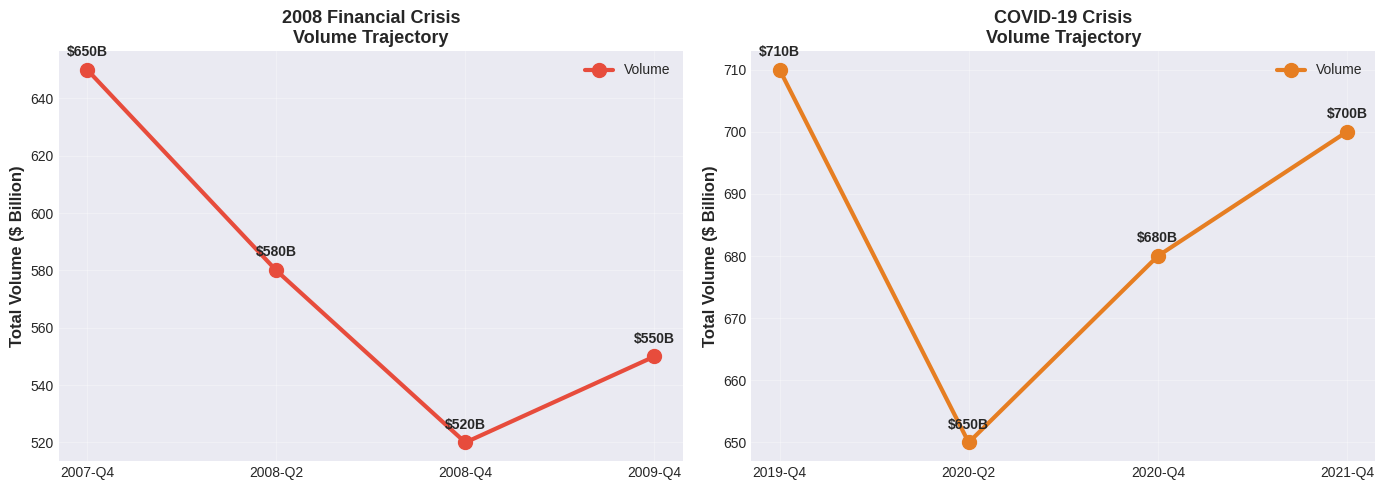

 Crisis comparison visualization saved


In [36]:


# Compare crises
print("\n" + "=" * 80)
print("CRISIS COMPARISON")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2008 Crisis trajectory
ax1 = axes[0]
crisis_08_quarters = ['2007-Q4', '2008-Q2', '2008-Q4', '2009-Q4']
crisis_08_data = df_evolution[df_evolution['Quarter'].isin(crisis_08_quarters)]

ax1.plot(range(len(crisis_08_data)), crisis_08_data['Total_Volume_B'], 
         marker='o', linewidth=3, markersize=10, color='#e74c3c', label='Volume')
ax1.set_xticks(range(len(crisis_08_data)))
ax1.set_xticklabels(crisis_08_data['Quarter'])
ax1.set_ylabel('Total Volume ($ Billion)', fontsize=12, fontweight='bold')
ax1.set_title('2008 Financial Crisis\nVolume Trajectory', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Annotate key points
for i, (x, y, q) in enumerate(zip(range(len(crisis_08_data)), 
                                   crisis_08_data['Total_Volume_B'], 
                                   crisis_08_data['Quarter'])):
    ax1.annotate(f'${y:.0f}B', xy=(x, y), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontweight='bold')

# COVID Crisis trajectory
ax2 = axes[1]
crisis_covid_quarters = ['2019-Q4', '2020-Q2', '2020-Q4', '2021-Q4']
crisis_covid_data = df_evolution[df_evolution['Quarter'].isin(crisis_covid_quarters)]

ax2.plot(range(len(crisis_covid_data)), crisis_covid_data['Total_Volume_B'], 
         marker='o', linewidth=3, markersize=10, color='#e67e22', label='Volume')
ax2.set_xticks(range(len(crisis_covid_data)))
ax2.set_xticklabels(crisis_covid_data['Quarter'])
ax2.set_ylabel('Total Volume ($ Billion)', fontsize=12, fontweight='bold')
ax2.set_title('COVID-19 Crisis\nVolume Trajectory', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

# Annotate key points
for i, (x, y, q) in enumerate(zip(range(len(crisis_covid_data)), 
                                   crisis_covid_data['Total_Volume_B'], 
                                   crisis_covid_data['Quarter'])):
    ax2.annotate(f'${y:.0f}B', xy=(x, y), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/home/aryan/Graph_ML/h3_crisis_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Crisis comparison visualization saved")